In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import os
import os.path
import sys
import tensorflow as tf
import math
from data_loader import DataLoader
from my_constants import Constants
from emotion_classifier import EmotionClassifier
import numpy as np
import scipy
import pandas as pd

np.random.seed(666)

# Logistics

In [2]:
model_name = 'FC'
batch_size = 90
seed = 666
filename = '/mas/u/asma_gh/uncnet/datasets/FER+/all.csv'
max_nrof_epochs=100000
hidden_layer_size=[128, 128]
keep_probability=0.8
weight_decay=0.0
n_epistemic = 100
n_aleatoric = 100

logs_base_dir = '/mas/u/asma_gh/uncnet/epoch_logs_model'
embedding_model = 'CASIA_WebFace_Inception_ResNet_v1'
embedding_layer = 'Mixed_7a'
learning_rate = 0.0001

# Load data

In [3]:
data_loader = DataLoader(filename, import_embedding=True, embedding_model=embedding_model,
                                      embedding_layer=embedding_layer, seed=seed)

Converting row 0 of dataframe to numpy array.
Converting row 100 of dataframe to numpy array.
Converting row 200 of dataframe to numpy array.
Converting row 300 of dataframe to numpy array.
Converting row 400 of dataframe to numpy array.
Converting row 500 of dataframe to numpy array.
Converting row 600 of dataframe to numpy array.
Converting row 700 of dataframe to numpy array.
Converting row 800 of dataframe to numpy array.
Converting row 900 of dataframe to numpy array.
Converting row 1000 of dataframe to numpy array.
Converting row 1100 of dataframe to numpy array.
Converting row 1200 of dataframe to numpy array.
Converting row 1300 of dataframe to numpy array.
Converting row 1400 of dataframe to numpy array.
Converting row 1500 of dataframe to numpy array.
Converting row 1600 of dataframe to numpy array.
Converting row 1700 of dataframe to numpy array.
Converting row 1800 of dataframe to numpy array.
Converting row 1900 of dataframe to numpy array.
Converting row 2000 of dataframe

Converting row 14600 of dataframe to numpy array.
Converting row 14700 of dataframe to numpy array.
Converting row 14800 of dataframe to numpy array.
Converting row 14900 of dataframe to numpy array.
Converting row 15000 of dataframe to numpy array.
Converting row 15100 of dataframe to numpy array.
Converting row 15200 of dataframe to numpy array.
Converting row 15300 of dataframe to numpy array.
Converting row 15400 of dataframe to numpy array.
Converting row 15500 of dataframe to numpy array.
Converting row 15600 of dataframe to numpy array.
Converting row 15700 of dataframe to numpy array.
Converting row 15800 of dataframe to numpy array.
Converting row 15900 of dataframe to numpy array.
Converting row 16000 of dataframe to numpy array.
Converting row 16100 of dataframe to numpy array.
Converting row 16200 of dataframe to numpy array.
Converting row 16300 of dataframe to numpy array.
Converting row 16400 of dataframe to numpy array.
Converting row 16500 of dataframe to numpy array.


Converting row 29000 of dataframe to numpy array.
Converting row 29100 of dataframe to numpy array.
Converting row 29200 of dataframe to numpy array.
Converting row 29300 of dataframe to numpy array.
Converting row 29400 of dataframe to numpy array.
Converting row 29500 of dataframe to numpy array.
Converting row 29600 of dataframe to numpy array.
Converting row 29700 of dataframe to numpy array.
Converting row 29800 of dataframe to numpy array.
Converting row 29900 of dataframe to numpy array.
Converting row 30000 of dataframe to numpy array.
Converting row 30100 of dataframe to numpy array.
Converting row 30200 of dataframe to numpy array.
Converting row 30300 of dataframe to numpy array.
Converting row 30400 of dataframe to numpy array.
Converting row 30500 of dataframe to numpy array.
Converting row 30600 of dataframe to numpy array.
Converting row 30700 of dataframe to numpy array.
Converting row 30800 of dataframe to numpy array.
Converting row 30900 of dataframe to numpy array.


In [4]:
test_labels, test_embeddings = data_loader.get_test_batch()
valid_labels, valid_embeddings = data_loader.get_valid_batch()

In [5]:
def load_model_dir(best_checkpoints, uncertainty_type):
    model_dir = None
    epoch_num = best_checkpoints[uncertainty_type]
    model_filename = f'{model_name}_{epoch_num}.ckpt-{epoch_num}'
    if uncertainty_type == 'none':
        root_dir = f'{logs_base_dir}/{embedding_model}/{embedding_layer}/{str(learning_rate)}/{uncertainty_type}'
        for sub_dir in os.listdir(root_dir):
            if sub_dir.startswith('.'):
                continue
            model_dir = os.path.join(os.path.join(root_dir, sub_dir), model_filename)
    # Note: it is NOT a typo below, based on that paper, 
    # only doing dropout (original epistemic condition)is enough for both epistemic and aleatoric
    elif uncertainty_type == 'epistemic':
        root_dir = f'/mas/u/asma_gh/uncnet/unc_hparam_logs/{embedding_model}/{embedding_layer}/1e-05/epistemic'
        model_dir = os.path.join(os.path.join(root_dir, '2019_04_26_13_17_00'), model_filename)

    if not model_dir:
        print ('Error! Did not find model.')
        return None
    return model_dir

# Load model and conduct inference

In [6]:
def get_performance_on_data(best_checkpoints, uncertainty_type, x, y):
    
    # Note: it is NOT a typo below, based on that paper, 
    # only doing dropout (original epistemic condition) is enough for both epistemic and aleatoric
    if uncertainty_type == 'both':
        model_dir = load_model_dir(best_checkpoints, uncertainty_type='epistemic')
    elif uncertainty_type == 'none':
        model_dir = load_model_dir(best_checkpoints, uncertainty_type)
        
    tf.reset_default_graph()
    with tf.Session() as sess:    
        saver = tf.train.import_meta_graph(f'{model_dir}.meta')
        saver.restore(sess, model_dir)

        tf_loss = tf.get_default_graph().get_tensor_by_name("loss:0")
        tf_acc = tf.get_default_graph().get_tensor_by_name("acc:0")
        tf_x = tf.get_default_graph().get_tensor_by_name("x:0")
        tf_y = tf.get_default_graph().get_tensor_by_name("y:0")
        tf_dropout_prob = tf.get_default_graph().get_tensor_by_name("dropout_prob:0")
        tf_logits = tf.get_default_graph().get_tensor_by_name("logits:0")
        
        def mc_sampling():
            # T x N x C
            mc_logits = []
            # T x N x C
            mc_class_probabilities = []
            # T
            mc_losses = []
            # T x N
            mc_entropies = []
            for i in range(n_epistemic):
                loss, logits = sess.run([tf_loss, tf_logits], feed_dict={
                    tf_x: x, tf_y: y, tf_dropout_prob: keep_probability})
                mc_logits.append(logits)
                class_probability = [scipy.special.softmax(l_i) for l_i in logits] 
                mc_class_probabilities.append(class_probability)
                mc_entropy = [scipy.stats.entropy(p_t) for p_t in class_probability]
                mc_entropies.append(mc_entropy)
                mc_losses.append(loss)
            mean_logits = np.mean(mc_logits, axis=0)
            mean_class_probabilities = np.mean(mc_class_probabilities, axis=0)
            score = calc_acc(mean_class_probabilities, y)
            total_u = [scipy.stats.entropy(p_t) for p_t in mean_class_probabilities]
            aleatoric_u = np.mean(mc_entropies, axis=0)
            epistemic_u = total_u - aleatoric_u
            return np.mean(mc_losses), score, mean_class_probabilities, total_u, aleatoric_u, epistemic_u

        def calc_acc(class_probabilities, y):
            predictions = np.argmax(class_probabilities, axis=1)
            target = np.argmax(y, axis=1)
            acc = np.mean(np.equal(target, predictions))
            return acc

        """Returns the model's performance on input data X and targets Y."""
        if uncertainty_type == 'none':
            loss, score, logits = sess.run([tf_loss, tf_acc, tf_logits], feed_dict={
                tf_x: x, tf_y: y, tf_dropout_prob: 1.0})
            class_probabilities = [scipy.special.softmax(l_i) for l_i in logits]
            return loss, score, class_probabilities, None, None, None
        
        elif uncertainty_type == 'both':
            return mc_sampling()

# Preparing for answering research questions
Loading best checkpoints per uncertainty type

In [7]:
# BEST_CHECKPOINTS = {'none': 1068, 'aleatoric':1012 ,'epistemic': 319 , 'both':53} # TODO only none is done
# BEST_CHECKPOINTS = {'none': 403, 'aleatoric':353 ,'epistemic': 406 , 'both':192}
# BEST_CHECKPOINTS = {'none': 403, 'aleatoric':428 ,'epistemic': 406 , 'both':192}
# BEST_CHECKPOINTS = {'none': 403, 'aleatoric':428 ,'epistemic': 474 , 'both':530}
# BEST_CHECKPOINTS = {'none': 403, 'aleatoric':4194 ,'epistemic': 474 , 'both':4079}
# BEST_CHECKPOINTS = {'none': 403, 'aleatoric':4194 ,'epistemic': 156000 , 'both':4079}
# BEST_CHECKPOINTS = {'none': 403, 'aleatoric':4194 ,'epistemic': 133000 , 'both':4079}
# BEST_CHECKPOINTS = {'none': 403, 'aleatoric':4194 ,'epistemic': 770 , 'both':4079}
# BEST_CHECKPOINTS = {'none': 403, 'aleatoric':4194 ,'epistemic': 597 , 'both':4079}
BEST_CHECKPOINTS = {'none': 403, 'aleatoric':4194 ,'epistemic': 819 , 'both':4079}

# using logits (_u) or probabilities (_p_u) uncertainties?
unc_postfix = '_u' #'_p_u' is legacy


print (load_model_dir(BEST_CHECKPOINTS, 'none'))
print (load_model_dir(BEST_CHECKPOINTS, 'epistemic'))

/mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
/mas/u/asma_gh/uncnet/unc_hparam_logs/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/1e-05/epistemic/2019_04_26_13_17_00/FC_819.ckpt-819


# Q1: Does modeling uncertainty improve accuracy?

Observation: The results are very similar on the hold-out test set. Modeling uncertainties is a bit higher, but not significant. 

Baseline acc: 0.54848, UncNet acc: 0.56943

#### Sanity check
Do the validation results map the tensorboard?

In [8]:
unc_types = ['none', 'both']
# Get validation results
print ('Validation set:')
for unc in unc_types:
    print (f'\nModeling {unc} uncertainties...')
    loss, score, class_probabilities, total_u, aleatoric_u, epistemic_u = get_performance_on_data(
        BEST_CHECKPOINTS, unc, valid_embeddings, valid_labels)
    print(f'loss: {loss:.5f}, score: {score:.5f}, class_probabilities: {class_probabilities}, total uncertainty: {total_u}, aleatoric uncertainty: {aleatoric_u}, epistemic uncertainty: {epistemic_u}')

Validation set:

Modeling none uncertainties...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
loss: 1.53035, score: 0.54912, class_probabilities: [array([0.31981698, 0.21512572, 0.01917354, 0.23162696, 0.09381683,
       0.02677649, 0.01027159, 0.02624959, 0.05714237], dtype=float32), array([0.45471013, 0.07609347, 0.0256297 , 0.29744136, 0.04101387,
       0.01052978, 0.00898827, 0.02163578, 0.06395774], dtype=float32), array([0.4050059 , 0.0964948 , 0.06714332, 0.13739534, 0.14578398,
       0.03128345, 0.02447554, 0.03248666, 0.05993111], dtype=float32), array([0.24466333, 0.08010031, 0.34131065, 0.08519024, 0.07871757,
       0.01645875, 0.07759508, 0.02353727, 0.05242665], dtype=float32), array([0.20789756, 0.13589652, 0.27974778, 0.10685043, 0.09861921,
       0.01767589

INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/unc_hparam_logs/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/1e-05/epistemic/2019_04_26_13_17_00/FC_819.ckpt-819
loss: 1.54567, score: 0.55975, class_probabilities: [[0.20509718 0.29439294 0.01348531 ... 0.01078636 0.01956991 0.06160447]
 [0.30833843 0.03429015 0.11408847 ... 0.02909625 0.0110014  0.08793698]
 [0.3630284  0.06237249 0.06443249 ... 0.01989841 0.03170529 0.05538275]
 ...
 [0.4110964  0.23901205 0.05591335 ... 0.02023382 0.02019471 0.06226337]
 [0.30464724 0.29575908 0.04276339 ... 0.01952291 0.02287075 0.05514712]
 [0.4651054  0.00781505 0.23245516 ... 0.03374647 0.01843756 0.04713227]], total uncertainty: [1.751707, 1.701261, 1.8104966, 1.756321, 1.835273, 1.3288796, 1.5138128, 1.6879396, 1.2179312, 0.45485824, 1.0630021, 1.5575683, 1.7818173, 1.5749958, 1.5304492, 1.7718557, 0.88561565, 1.5074373, 1.7833624, 1.7322054, 2.045442, 1.5862529, 1.5821708, 1.1946964, 1.7952069, 1.5842228, 1.4867479, 1.053496, 1.72

#### How about the unseen test set?

In [9]:
unc_types = ['none', 'both']
# Get Test results
print ('Test set:')
for unc in unc_types:
    print (f'\nModeling {unc} uncertainties...')
    loss, score, class_probabilities, total_u, aleatoric_u, epistemic_u = get_performance_on_data(
        BEST_CHECKPOINTS, unc, test_embeddings, test_labels)
    print(f'loss: {loss:.5f}, score: {score:.5f}, class_probabilities: {class_probabilities}, total uncertainty: {total_u}, aleatoric uncertainty: {aleatoric_u}, epistemic uncertainty: {epistemic_u}')

Test set:

Modeling none uncertainties...
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
loss: 1.49306, score: 0.54848, class_probabilities: [array([0.07437199, 0.10068852, 0.34969157, 0.05259977, 0.25937063,
       0.01313742, 0.09410726, 0.00466578, 0.05136716], dtype=float32), array([0.40645865, 0.21904269, 0.09299298, 0.12284026, 0.03571182,
       0.01142172, 0.03517375, 0.0259076 , 0.05045038], dtype=float32), array([0.22130667, 0.3419293 , 0.08057819, 0.10636271, 0.11585012,
       0.02785291, 0.03613543, 0.01902513, 0.05095953], dtype=float32), array([0.40291703, 0.27921173, 0.06625327, 0.1098311 , 0.03272419,
       0.01246785, 0.02593529, 0.02569832, 0.04496128], dtype=float32), array([0.07812958, 0.8529222 , 0.00647576, 0.02138066, 0.0138247 ,
       0.00598036, 0.00348727, 0.00539922, 0.01240023], dtype=float32), array([0.06936495, 0.86031973, 0.01555

INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/unc_hparam_logs/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/1e-05/epistemic/2019_04_26_13_17_00/FC_819.ckpt-819
loss: 1.51506, score: 0.57055, class_probabilities: [[0.11407669 0.09585295 0.18751572 ... 0.25818816 0.0138652  0.07159684]
 [0.2444315  0.3483617  0.10619385 ... 0.04535043 0.03220405 0.05669535]
 [0.181571   0.26276654 0.08539286 ... 0.08306908 0.02141332 0.06664521]
 ...
 [0.5835413  0.10151876 0.00839487 ... 0.0023768  0.01286536 0.04600824]
 [0.39085847 0.09894835 0.00975355 ... 0.00794616 0.03730758 0.05855116]
 [0.62730676 0.02373369 0.05622286 ... 0.01605087 0.0242847  0.04773698]], total uncertainty: [1.9497055, 1.8164239, 1.9848983, 1.7282059, 1.1229827, 0.13664614, 1.5229852, 1.6540434, 1.8910477, 1.7837582, 1.700188, 1.6575582, 1.7892034, 1.8702931, 1.2764431, 1.2668626, 1.735255, 1.7140737, 0.940423, 1.1381513, 1.691131, 1.2606326, 1.1072792, 1.618651, 1.7627506, 1.1159151, 1.6725631, 1.8037212, 1.87

# Q2: Does excluding the points with high uncertainty, improve accuracy?

Observation: 

Sorting by aleatoric, epistemic, or total uncertainties improves both baseline and UncNet similarly.

All samples:

Basline: 0.54848, UncNet acc: 0.56943

top 75% confident samples:

aleatoric - Baseline: 0.60209, Uncnet: 0.62481

epistemic - Baseline: 0.55812, Uncnet: 0.57452

total - Baseline: 0.60209, Uncnet: 0.62332

In [10]:
dataset = pd.read_csv(filename)

train = dataset[dataset['dataset'] == 'Training'].reset_index(drop=True)
train['original_ind'] = train.index

test = dataset[dataset['dataset'] == 'PublicTest'].reset_index(drop=True)
test['original_ind'] = test.index

In [11]:
loss, score, class_probabilities, total_u, aleatoric_u, epistemic_u = get_performance_on_data(
        BEST_CHECKPOINTS, 'both', test_embeddings, test_labels)

INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/unc_hparam_logs/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/1e-05/epistemic/2019_04_26_13_17_00/FC_819.ckpt-819


In [12]:
test['aleatoric_u'] = aleatoric_u
test['epistemic_u'] = epistemic_u
test['total_u'] = total_u

In [13]:
def find_unc_samples(test, uncertainty_type, percentage=0.75, sort_ascending=True):
    '''
    Find samples that are in the [percentage] quantile with 
    highest or lowest uncertainty values based on [sort_ascending]
    '''
    sorted_test = test.sort_values(by=f'{uncertainty_type}{unc_postfix}', ascending=sort_ascending)
    max_ind = int(percentage*len(sorted_test))
    sub_index = sorted_test.index[0:max_ind]
    return sub_index

for unc in ['aleatoric', 'epistemic', 'total']:
    print (f'Sorting based on uncertainty type: {unc}...')
    sub_indices = find_unc_samples(test, unc)
    sub_test_embeddings = test_embeddings[sub_indices]
    sub_test_labels = test_labels[sub_indices]
    for unc_type in ['none', 'both']:
        print(f'New performance metrics for {unc_type}:')
        loss, score, class_probabilities, total_u, aleatoric_u, epistemic_u = get_performance_on_data(BEST_CHECKPOINTS, unc_type, sub_test_embeddings, sub_test_labels)
        print(f'loss: {loss:.5f}, score: {score:.5f}, class_probabilities: {class_probabilities}, total uncertainty: {total_u}, aleatoric uncertainty: {aleatoric_u}, epistemic uncertainty: {epistemic_u}')
        

Sorting based on uncertainty type: aleatoric...
New performance metrics for none:
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
loss: 1.37880, score: 0.60171, class_probabilities: [array([5.0949482e-03, 9.8842555e-01, 1.6873390e-03, 1.1074850e-03,
       1.2227054e-03, 4.4666923e-04, 4.7854325e-04, 2.0680265e-04,
       1.3301086e-03], dtype=float32), array([9.8466352e-03, 8.9143115e-01, 2.3450725e-02, 1.2016203e-02,
       4.0519547e-02, 4.4852011e-03, 7.0383647e-03, 5.2055821e-04,
       1.0691709e-02], dtype=float32), array([0.12904248, 0.6917798 , 0.01960312, 0.06375851, 0.03427017,
       0.01471772, 0.01020763, 0.01114775, 0.0254728 ], dtype=float32), array([0.02603013, 0.94885206, 0.00245316, 0.0061001 , 0.00679795,
       0.00245463, 0.00110269, 0.00121461, 0.00499448], dtype=float32), array([2.3688639e-03, 9.8988110e-01, 1.1361875e-03, 1.6975405e-03,
  

INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/unc_hparam_logs/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/1e-05/epistemic/2019_04_26_13_17_00/FC_819.ckpt-819
loss: 1.40392, score: 0.62221, class_probabilities: [[2.53222464e-03 9.94063854e-01 1.07354904e-03 ... 2.07672943e-04
  1.03127270e-04 6.06919464e-04]
 [2.00147717e-03 9.80539560e-01 1.25256518e-03 ... 4.07872198e-04
  1.95705215e-04 2.13150401e-03]
 [1.23570720e-02 9.66169417e-01 3.52244149e-03 ... 1.13494520e-03
  6.61606842e-04 4.46085772e-03]
 ...
 [1.82872832e-01 7.89986700e-02 4.15806621e-01 ... 1.03643171e-01
  1.23866871e-02 5.03095090e-02]
 [3.84658277e-01 1.24821395e-01 4.60572131e-02 ... 1.50081972e-02
  1.94227640e-02 6.58888891e-02]
 [3.78400922e-01 1.56082496e-01 1.41265774e-02 ... 9.28825047e-03
  3.57867852e-02 5.59287891e-02]], total uncertainty: [0.046212558, 0.12692343, 0.20701958, 0.111371525, 0.0898791, 0.09825816, 0.16143829, 0.1471021, 0.13123445, 0.11658514, 0.13329695, 0.112260394, 0.13918

New performance metrics for none:
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
loss: 1.48748, score: 0.56073, class_probabilities: [array([5.0949482e-03, 9.8842555e-01, 1.6873390e-03, 1.1074850e-03,
       1.2227054e-03, 4.4666923e-04, 4.7854325e-04, 2.0680265e-04,
       1.3301086e-03], dtype=float32), array([0.02603013, 0.94885206, 0.00245316, 0.0061001 , 0.00679795,
       0.00245463, 0.00110269, 0.00121461, 0.00499448], dtype=float32), array([0.03661518, 0.90105397, 0.00874149, 0.01451592, 0.01679874,
       0.00543812, 0.00379095, 0.00243874, 0.01060696], dtype=float32), array([0.32441032, 0.23460199, 0.0581652 , 0.20505375, 0.05482689,
       0.0173688 , 0.02664151, 0.0232215 , 0.05571008], dtype=float32), array([0.01012048, 0.74611306, 0.15893812, 0.00866017, 0.02689583,
       0.00369172, 0.03220439, 0.00082752, 0.01254862], dtype=float32), array([0.039

INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/unc_hparam_logs/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/1e-05/epistemic/2019_04_26_13_17_00/FC_819.ckpt-819
loss: 1.50065, score: 0.57973, class_probabilities: [[2.90202047e-03 9.93384838e-01 9.54387011e-04 ... 1.96841342e-04
  1.08111824e-04 6.53937226e-04]
 [7.38979876e-03 9.86434162e-01 3.84102983e-04 ... 1.46558552e-04
  3.25546251e-04 1.39888492e-03]
 [1.95924416e-02 9.52198565e-01 5.13680652e-03 ... 1.85902894e-03
  1.29932363e-03 5.48116444e-03]
 ...
 [4.26653892e-01 6.19113408e-02 2.30961502e-01 ... 4.69050929e-02
  2.13733409e-02 5.17822132e-02]
 [1.59909148e-02 7.67726839e-01 9.98725146e-02 ... 2.81918198e-02
  1.46498159e-03 1.70669816e-02]
 [4.02663499e-01 1.15463935e-01 3.02296225e-02 ... 1.31940963e-02
  2.41767187e-02 6.80484176e-02]], total uncertainty: [0.05063907, 0.09156484, 0.27532405, 1.9283578, 0.10986221, 0.1917519, 0.2174293, 0.06035056, 0.14053908, 0.10890082, 1.6003412, 0.15746963, 0.098076046,

INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
loss: 1.37441, score: 0.60507, class_probabilities: [array([5.0949482e-03, 9.8842555e-01, 1.6873390e-03, 1.1074850e-03,
       1.2227054e-03, 4.4666923e-04, 4.7854325e-04, 2.0680265e-04,
       1.3301086e-03], dtype=float32), array([0.02603013, 0.94885206, 0.00245316, 0.0061001 , 0.00679795,
       0.00245463, 0.00110269, 0.00121461, 0.00499448], dtype=float32), array([9.8466352e-03, 8.9143115e-01, 2.3450725e-02, 1.2016203e-02,
       4.0519547e-02, 4.4852011e-03, 7.0383647e-03, 5.2055821e-04,
       1.0691709e-02], dtype=float32), array([2.3688639e-03, 9.8988110e-01, 1.1361875e-03, 1.6975405e-03,
       2.5900959e-03, 5.5994134e-04, 3.4147131e-04, 1.0118223e-04,
       1.3236272e-03], dtype=float32), array([0.12904248, 0.6917798 , 0.01960312, 0.06375851, 0.03427017,
       0.01471772, 0.01020763, 0.01114775, 0.02547

INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/unc_hparam_logs/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/1e-05/epistemic/2019_04_26_13_17_00/FC_819.ckpt-819
loss: 1.39797, score: 0.62519, class_probabilities: [[1.8651861e-03 9.9578798e-01 6.8626396e-04 ... 1.4191309e-04
  6.3889667e-05 4.2402773e-04]
 [1.1106857e-02 9.8086250e-01 4.5308436e-04 ... 1.6379259e-04
  4.1736255e-04 1.7692655e-03]
 [1.8619071e-03 9.7994864e-01 1.6440058e-03 ... 6.2897243e-04
  1.3755943e-04 2.0977678e-03]
 ...
 [2.9457647e-01 3.2105103e-01 1.3962840e-01 ... 5.6275353e-02
  2.1042639e-02 4.4456095e-02]
 [3.7312505e-01 8.1600621e-02 2.8220052e-02 ... 1.6012272e-02
  2.8225703e-02 7.8828864e-02]
 [4.4632876e-01 1.2172300e-01 7.9891071e-02 ... 4.5480814e-02
  2.9674280e-02 6.9917567e-02]], total uncertainty: [0.03415665, 0.12106843, 0.12839018, 0.07052761, 0.18062297, 0.08411226, 0.20118554, 0.13258441, 0.1527733, 0.15677449, 0.11553015, 0.1497125, 0.14439769, 0.111614615, 0.11891472, 0.1203980

# Q3: Is there a relationship between inter-rater agreement and uncertainty?

Observation:

There is a significant positive correlation between aleatoric/total uncertainty and disagreement_p/entropy.
Epistemic is not correlated, as expected.

<Figure size 360x360 with 0 Axes>

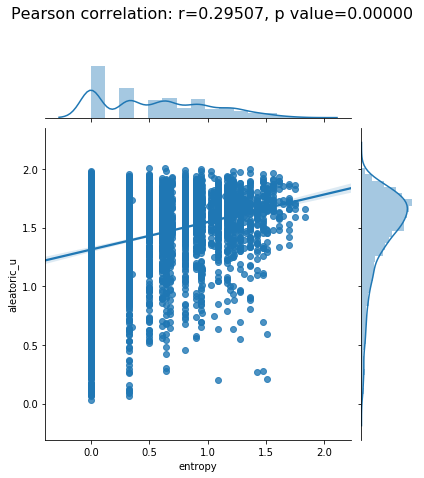

<Figure size 360x360 with 0 Axes>

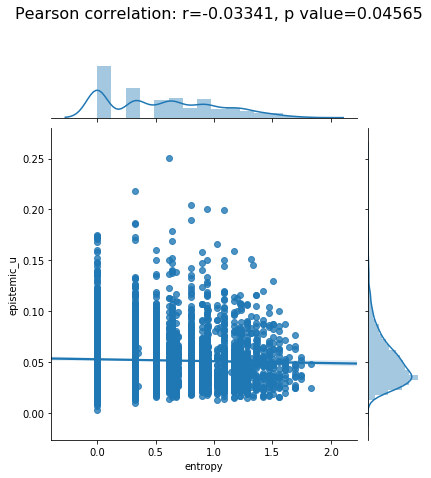

<Figure size 360x360 with 0 Axes>

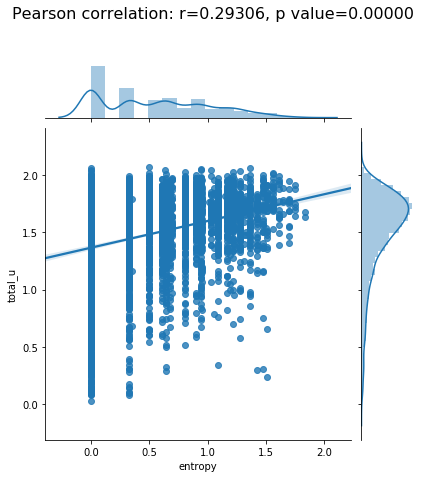

<Figure size 360x360 with 0 Axes>

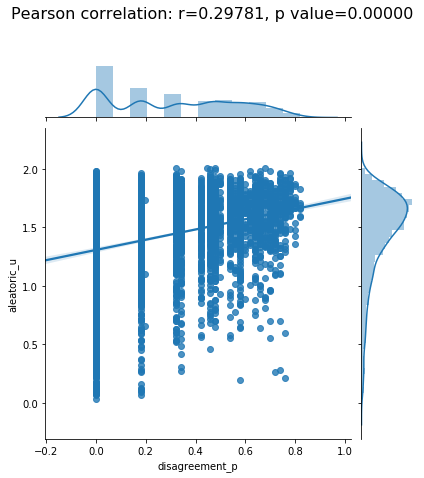

<Figure size 360x360 with 0 Axes>

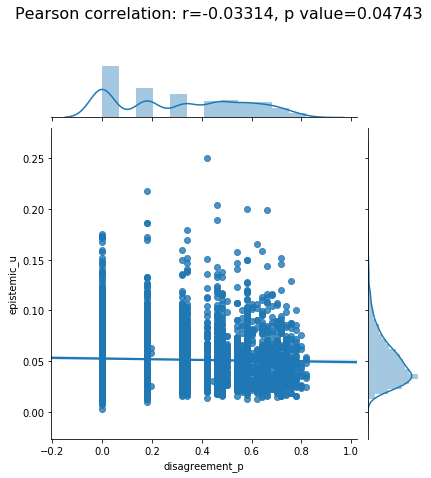

<Figure size 360x360 with 0 Axes>

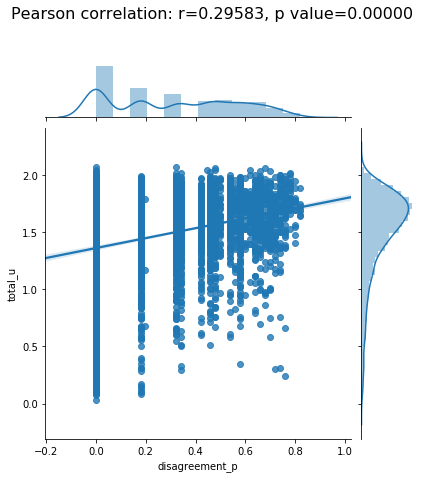

In [14]:
def comparison_plots(test, x, y):
    plt.figure(figsize=(5,5))
    g = sns.jointplot(test[x], test[y], kind="reg")
    r, p = scipy.stats.pearsonr(test[x], test[y])
    plt.suptitle(f'Pearson correlation: r={r:.5f}, p value={p:.5f}', size=16, y=1.1)
    plt.ylabel(y)
    plt.xlabel(x)
    
for x in ['entropy', 'disagreement_p']:
    comparison_plots(test, x, f'aleatoric{unc_postfix}')
    comparison_plots(test, x, f'epistemic{unc_postfix}')
    comparison_plots(test, x, f'total{unc_postfix}')


# Q4: What do samples with high/low aleatoric/epistemic uncertainty look like?

Observations:

Samples with low aleatoric uncertainty have higher inter-annotator agreement, i.e. less spread in the annotations distribution. Inversely, high aleatoric uncertainty -> lower agreement samples with wiered cropps when thumbnailer went wrong, or more occlusion

It is hard to explain what low epistemic uncertainty explains.

Uncertainty type: aleatoric
Uncertainty type: epistemic
Uncertainty type: total


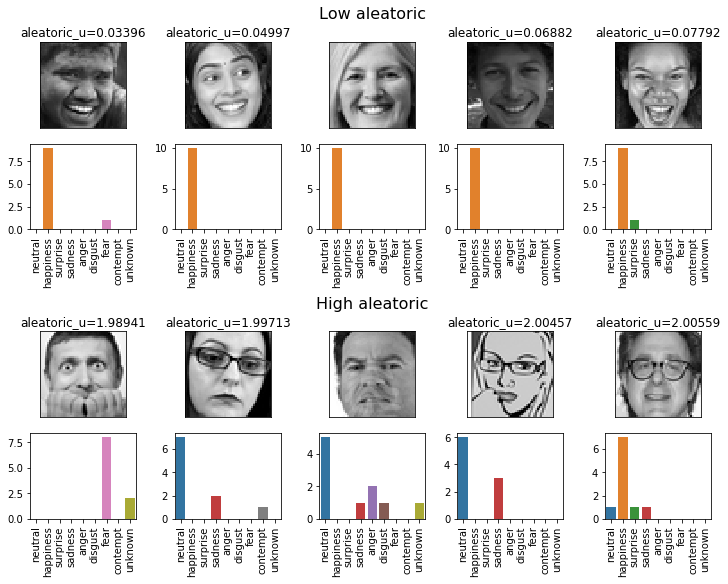

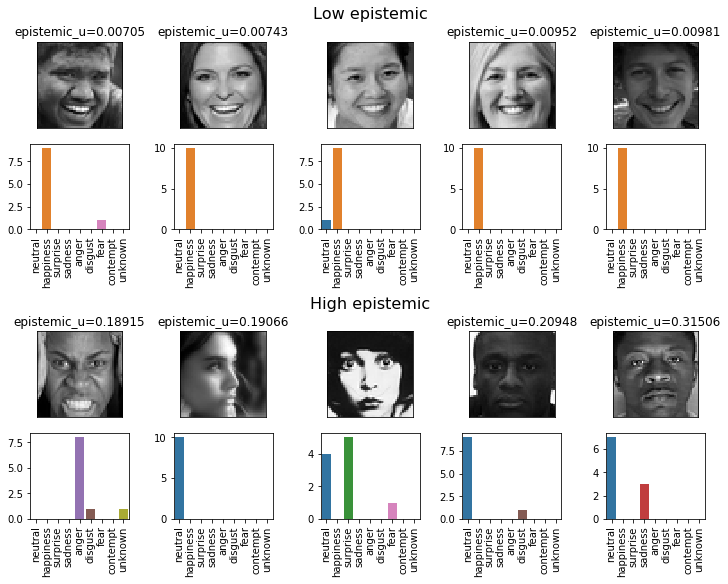

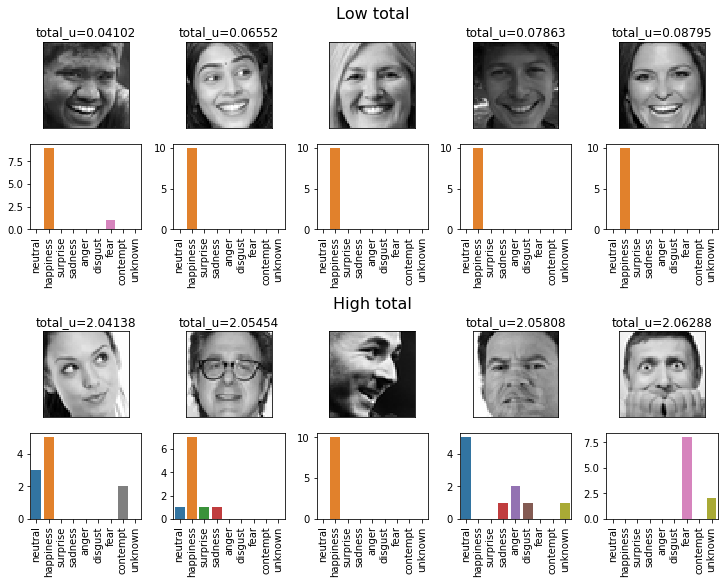

In [42]:
EMOTION_COLS = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt' ,'unknown']
def _plot_img_hist(inp, axes, ax_i, ax_j, ttl_col):
    img_ax = axes[ax_i, ax_j]
    hist_ax = axes[ax_i+1, ax_j]
    
    NEW_SHAPE = (48, 48)
    img_arr = np.array([int(i) for i in inp['pixels'].split(' ')])
    img_arr = np.reshape(img_arr, NEW_SHAPE)
    img_ax.set_title(f'{ttl_col}={inp[ttl_col]:.5f}')
    img_ax.imshow(img_arr, cmap='gray')
    img_ax.set_xticks([])
    img_ax.set_yticks([])
    
    sns.barplot(np.arange(len(EMOTION_COLS)), list(inp[EMOTION_COLS]), ax=hist_ax)
    hist_ax.set_xticklabels(EMOTION_COLS, rotation='vertical')


# Show n images with highest disagreement and n images with lowest disagreement probability
def show_extreme_cases(inp, n, ttl_col):
    f, axes = plt.subplots(4, n, figsize=(n*2, 8), constrained_layout=True)
    for i in range(n):
        _plot_img_hist(inp.iloc[i], axes, 0, i, f'{ttl_col}{unc_postfix}')
    axes[0, int(n/2)].set_title(f'Low {ttl_col}', size=16, y=1.2)
    
    for i in range(n):
        _plot_img_hist(inp.iloc[len(inp)-1-i], axes, 2, n-i-1, f'{ttl_col}{unc_postfix}')
    axes[2, int(n/2)].set_title(f'High {ttl_col}', size=16, y=1.2)

for unc in ['aleatoric', 'epistemic', 'total']:
    # removing the zombie photo for fairness reasons!
    fairness_test = test.drop(874)
    print (f'Uncertainty type: {unc}')
    sorted_test = fairness_test.sort_values(by=f'{unc}{unc_postfix}')
    show_extreme_cases(sorted_test, 5, unc)
    

# Q5: Maybe doesn't influence accuracy, but are the softmax outputs better calibrated?

Note that because of the way we formed the problem and used aggregate user ratings, traditional calibration metrics such as Expected Calibration Error (ECE), Maximum Calibration Error (MCE), and reliability diagram may not be relevant. Here, we use distribution distance metrics between predicted and input probabilities.

Observations:

jensen shannon distance of probabilites in uncnet codition is slightly higher :|

But, the cosine similarity of probabilities with uncnet is higher, as we expect, though the differences are small.

In [87]:
_, _, baseline_class_probabilities, _, _, _= get_performance_on_data(
    BEST_CHECKPOINTS, 'none', test_embeddings, test_labels)

_, _, uncnet_class_probabilities, _, _, _ = get_performance_on_data(
    BEST_CHECKPOINTS, 'both', test_embeddings, test_labels)

INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403


INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403


INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/unc_hparam_logs/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/1e-05/epistemic/2019_04_26_13_17_00/FC_819.ckpt-819


INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/unc_hparam_logs/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/1e-05/epistemic/2019_04_26_13_17_00/FC_819.ckpt-819


## Implementation of calibration metrics: ECE, SCE, ACE, TACE (Dustin Tran et al.)

### Is uncnet more confident in its true predictions and less confident in false predictions? YES

In [119]:
def dbg(df, ttl):
    print (ttl)
    for val in [True, False]:
        sub_df = df[df['is_correct']==val]
        print (f'is correct? {val}, mean conf: {np.mean(sub_df["pred_max_conf"]):.3f}')
    print()

dbg(baseline_cal_df, 'baseline')
dbg(uncnet_cal_df, 'uncnet')

baseline
is correct? True, mean conf: 0.528
is correct? False, mean conf: 0.420

uncnet
is correct? True, mean conf: 0.538
is correct? False, mean conf: 0.418



### Using JN's implementation

In [303]:
# JN's implementation

import collections
import math

class CalibrationMetrics(object):
    """Container for calibration metrics."""
    
    def maximum_calibration_error(self, softmax, y_test, n_bins=10, cc=False):
        """Computes Maximum Calibration Error.

        Args:
          softmax: softmax from forward pass.
          y_test: validation labels as integer class values.
          n_bins: number of bins to fill.
          cc: whether to condition the metric on each class before aggregating.

        Returns:
          mce: expected calibration error.
          bin_accuracies: accuracies by bin.
        """
        del cc  # unused arg
        xbins = np.arange(n_bins) * (1. / n_bins)
        binned_predictions = np.digitize(np.max(softmax, axis=1), bins=xbins)
        correctness = y_test == np.argmax(softmax, axis=1)
        correct = collections.Counter(binned_predictions[correctness == 1])
        incorrect = collections.Counter(binned_predictions[correctness == 0])

        bin_accuracies = np.zeros(n_bins)
        # If there are no correct predictions, this correctly leaves zero accuracy
        for key in correct.keys():
            bin_accuracies[key - 1] = correct[key] / float(correct[key] + incorrect[key])
        for i in range(n_bins):
            if i not in correct.keys():
                correct[i] = 0.0
            if i not in incorrect.keys():
                incorrect[i] = 0.0
        mce = 0.0
        for key in range(1, n_bins + 1):
            if correct[key] + incorrect[key] > 0:
                bin_accuracy = bin_accuracies[key - 1]
                confidence = np.mean(np.max(softmax, axis=1)[binned_predictions == key])
                mce = np.max([mce, np.abs(confidence - bin_accuracy)])
                
        return mce, bin_accuracies
    
    def expected_calibration_error(self, softmax, y_test, n_bins=10, cc=False):
        """Computes Expected Calibration Error.

        Args:
          softmax: softmax from forward pass.
          y_test: validation labels as integer class values.
          n_bins: number of bins to fill.
          cc: whether to condition the metric on each class before aggregating.

        Returns:
          ece: expected calibration error.
          bin_accuracies: accuracies by bin.
        """
        del cc  # unused arg
        xbins = np.arange(n_bins) * (1. / n_bins)
        binned_predictions = np.digitize(np.max(softmax, axis=1), bins=xbins)
        correctness = y_test == np.argmax(softmax, axis=1)
        correct = collections.Counter(binned_predictions[correctness == 1])
        incorrect = collections.Counter(binned_predictions[correctness == 0])

        bin_accuracies = np.zeros(n_bins)
        # If there are no correct predictions, this correctly leaves zero accuracy
        for key in correct.keys():
            bin_accuracies[key - 1] = correct[key] / float(correct[key] + incorrect[key])
        for i in range(n_bins):
            if i not in correct.keys():
                correct[i] = 0.0
            if i not in incorrect.keys():
                incorrect[i] = 0.0
        ece = 0.0
        for key in range(1, n_bins + 1):
            if correct[key] + incorrect[key] > 0:
                weighting = float(correct[key] + incorrect[key]) / float(len(y_test))
                bin_accuracy = bin_accuracies[key - 1]
                confidence = np.mean(np.max(softmax, axis=1)[binned_predictions == key])
                ece += weighting * np.abs(confidence - bin_accuracy)
        return ece, bin_accuracies

    def thresholded_adaptive_calibration(self, softmax, y_test, n_bins=10, threshold=0.01, cc=False):
        """Adaptive calibration ranges with truncation of small values.

        Args:
          softmax: softmax from forward pass.
          y_test: validation labels as integer class values.
          n_bins: number of bins to fill.
          threshold: value to threshold softmax at.
          cc: whether to condition the metric on each class before aggregating.

        Returns:
          calibration_error: tce.
          bins: calibration ranges chosen by tce.

        """
        flattened = softmax.reshape(softmax.shape[0] * softmax.shape[1],)
        thresholded = np.sort(flattened[flattened >= threshold])
        indices = []
        switching_int = int(((thresholded.shape[0]/float(n_bins)) % 1) * n_bins)
        index = 0
        # Compute switching point, go up to switching point times the number of bins
        while index < switching_int:
            indices.append(index)
            index += int(math.ceil(thresholded.shape[0]/float(n_bins)))
        while index < thresholded.shape[0]:
            indices.append(index)
            index += int(math.floor(thresholded.shape[0]/float(n_bins)))
        indices = np.array(indices)
        bins = thresholded[indices.astype(np.int32)]
        # Values below threshold fall into a 0 bin
        binned_predictions = np.digitize(softmax, bins=bins)
        if cc:
            correct_bins = binned_predictions[y_test == 1]
        else:
            correct_bins = binned_predictions[range(len(binned_predictions)), y_test]
        unique_correct_bins, correct_bin_counts = np.unique(
            correct_bins, return_counts=True)
        total_dict = dict(zip(unique_correct_bins, correct_bin_counts))
        unique, counts = np.unique(binned_predictions, return_counts=True)
        counts_dict = dict(zip(unique, counts))
        bin_accuracies = np.zeros(n_bins)
        for i in range(n_bins):
            try:
                bin_accuracies[i] = total_dict[i + 1] / float(counts_dict[i + 1])
            except KeyError:
                pass
        mean_probability = np.zeros(n_bins)
        for i in range(n_bins):
            if not np.isnan(np.mean(softmax[binned_predictions == i + 1])):
                mean_probability[i] = np.mean(softmax[binned_predictions == i + 1])
        calibration_error = np.sum(np.abs(bin_accuracies - mean_probability) / n_bins)
        return calibration_error, bins

    def adaptive_calibration(self, softmax, y_test, n_bins=10, cc=False):
        """Adaptive calibration ranges without truncation of small values.

        Args:
          softmax: softmax from forward pass.
          y_test: validation labels as integer class values.
          n_bins: number of bins to fill.
          cc: whether to condition the metric on each class before aggregating.

        Returns:
          calibration_error: ace.
          bins: clibration ranges chosen by ace.
        """
        return thresholded_adaptive_calibration(softmax, y_test, n_bins, threshold=0.0, cc=cc)

    def static_calibration(self, softmax, y_test, n_bins=10, cc=False):
        """Evenly spaced binning scheme, considering all softmax values.

        Args:
          softmax: softmax from forward pass.
          y_test: validation labels as integer class values.
          n_bins: number of bins to fill.
          cc: whether to condition the metric on each class before aggregating.

        Returns:
          calibration_error: 'static' calibration error.
          bins: clibration ranges chosen by 'static' calibration error.
        """
        # Create evenly spaced binning scheme from 0 to 1
        bins = np.arange(n_bins) * (1. / n_bins)
        # Put the softmax into the binning scheme
        binned_predictions = np.digitize(softmax, bins=bins)
        if cc:
            correct_bins = binned_predictions[y_test == 1]
        else:
            correct_bins = binned_predictions[range(len(binned_predictions)), y_test]
        unique_correct_bins, correct_bin_counts = np.unique(correct_bins, return_counts=True)
        correct_dict = dict(zip(unique_correct_bins, correct_bin_counts))
        unique, counts = np.unique(binned_predictions, return_counts=True)
        counts_dict = dict(zip(unique, counts))
        bin_accuracies = np.zeros(n_bins)
        for i in range(n_bins):
            try:
                bin_accuracies[i] = correct_dict[i + 1] / float(counts_dict[i + 1])
            except KeyError:
                pass
        mean_probability = np.zeros(n_bins)
        for i in range(n_bins):
            if not np.isnan(np.mean(softmax[binned_predictions == i + 1])):
                mean_probability[i] = np.mean(softmax[binned_predictions == i + 1])
        weighting = np.zeros(n_bins)
        prediction_count = softmax.shape[0] * softmax.shape[1]
        for i in range(n_bins):
            try:
                weighting[i] = counts_dict[i + 1] / float(prediction_count)
            except KeyError:
                pass
        new_metric = (bin_accuracies - mean_probability) * weighting
        static_calibration_error = np.sum(np.abs(new_metric))
        return static_calibration_error, bin_accuracies

    def make_class_conditional(self, error_metric, softmax, y_test, n_bins=10, cc=True):
        """Allows calls to the class conditional version of each metric.

        Examples of use:

        cm = CalibrationMetrics()
        cc_tace, cc_error = cm.make_class_conditional(
            cm.thresholded_adaptive_calibration, softmax, y_test, n_bins)
        cc_tace, cc_error = cm.make_class_conditional(
          cm.adaptive_calibration, softmax, y_test, n_bins)
        cc_tace, cc_error = cm.make_class_conditional(
          cm.static_calibration, softmax, y_test, n_bins)
        cc_tace, cc_error = cm.make_class_conditional(
            cm.expected_calibration_error, softmax, y_test, n_bins)

        Args:
          error_metric: calibration metric to call.
          softmax: softmax from forward pass.
          y_test: validation labels as integer class values.
          n_bins: number of bins to fill.
          cc: whether to condition the metric on each class before aggregating.

        Returns:
          class_conditional_error: calibration error.
          class_conditional_errors: class specific calibration error.

        """
        class_conditional_error = 0
        class_conditional_errors = []
        for i in range(softmax.shape[1]):
            error, _ = error_metric(softmax[:, i].reshape(softmax.shape[0], 1), (y_test == i).astype(np.int32),
                                    n_bins=n_bins, cc=cc)
            class_conditional_error += error
            class_conditional_errors.append(error)
        return class_conditional_error / softmax.shape[1], class_conditional_errors

    def brier_calibration_score(self, softmax, y_test):
        """Brier score for multiple classes, as defined in the original 1950 paper.

        https://web.archive.org/web/20171023012737/https://docs.lib.noaa.gov/rescue/mwr/078/mwr-078-01-0001.pdf
        Brier score is the same as the calibration error, so zero is perfect.

        Args:
          softmax: softmax from forward pass.
          y_test: validation labels as integer class values.

        Returns:
          Brier score.
        """
        zeros = np.zeros(softmax.shape)
        zeros[range(len(softmax)), y_test] += 1
        return np.sum((zeros - softmax)**2) / len(softmax)

def calibration(y_test, softmax, n_bins=10, cc=False):
    """Calls calibration functions.

    Args:
    y_test: correct labels.
    softmax: softmax probabilities.
    n_bins: number of bins to fill.
    cc: whether to condition the metric on each class before aggregating.

    Returns:
    bin_accuracies: accuracies in each bin.
    ece: expected calibration accuracy.
    sce: static calibration accuracy.
    ace: adaptive calibration accuracy.
    ace_bins: adaptive calibration ranges chosen by ace.
    tce: truncated calibration accuracy.
    tce_bins: adaptive calibration ranges chosen by tce.
    """
    cm = CalibrationMetrics()
    if cc:
        sce, _ = cm.make_class_conditional(cm.static_calibration, softmax, y_test, n_bins)
        ace, ace_bins = cm.make_class_conditional(cm.adaptive_calibration, softmax, y_test, n_bins)
        tce, tce_bins = cm.make_class_conditional(cm.thresholded_adaptive_calibration, softmax, y_test, n_bins)
        ece, bin_accuracies = cm.make_class_conditional(cm.expected_calibration_error, softmax, y_test, n_bins)
        mce, bin_accuracies = cm.make_class_conditional(cm.maximum_calibration_error, softmax, y_test, n_bins)
    else:
        sce, _ = cm.static_calibration(softmax, y_test, n_bins=n_bins)
        ace, ace_bins = cm.adaptive_calibration(softmax, y_test, n_bins)
        tce, tce_bins = cm.thresholded_adaptive_calibration(softmax, y_test, n_bins)
        ece, bin_accuracies = cm.expected_calibration_error(softmax, y_test, n_bins)
        mce, bin_accuracies = cm.maximum_calibration_error(softmax, y_test, n_bins)
    bce = brier_calibration_score(softmax, y_test)
    return bin_accuracies, ece, mce, sce, ace, ace_bins, tce, tce_bins, bce


def print_calib_results(b):
    _, baseline_ece, baseline_mce, baseline_sce, baseline_ace, _, baseline_tce, _, baseline_bce = calibration(
        np.argmax(test_labels, axis=1), np.array(baseline_class_probabilities), n_bins=b)
    _, uncnet_ece, uncnet_mce, uncnet_sce, uncnet_ace, _, uncnet_tce, _, uncnet_bce = calibration(
        np.argmax(test_labels, axis=1), np.array(uncnet_class_probabilities), n_bins=b)
    _, true_ece, true_mce, true_sce, true_ace, _, true_tce, _, true_bce = calibration(
        np.argmax(test_labels, axis=1), np.array(test_labels), n_bins=b)
        
    print(f'#bins={b}\n\nBaseline:\n'
          f'ECE={baseline_ece:.3f}, MCE={baseline_mce:.3f}, SCE={baseline_sce:.3f}, ACE={baseline_ace:.3f}, TACE={baseline_tce:.3f}, BCE={baseline_bce:.3f}\n\n'
          f'UncNet:\n'
          f'ECE={uncnet_ece:.3f}, MCE={uncnet_mce:.3f}, SCE={uncnet_sce:.3f}, ACE={uncnet_ace:.3f}, TACE={uncnet_tce:.3f}, BCE={uncnet_bce:.3f}\n\n'
          f'True probabilities:\n'
          f'ECE={true_ece:.3f}, MCE={true_mce:.3f}, SCE={true_sce:.3f}, ACE={true_ace:.3f}, TACE={true_tce:.3f}, BCE={true_bce:.3f}\n\n')


print_calib_results(b=10)
print_calib_results(b=100)
print_calib_results(b=1000)

#bins=10

Baseline:
ECE=0.070, MCE=0.195, SCE=0.019, ACE=0.021, TACE=0.021, BCE=0.602

UncNet:
ECE=0.082, MCE=0.185, SCE=0.021, ACE=0.022, TACE=0.024, BCE=0.587

True probabilities:
ECE=0.234, MCE=0.705, SCE=0.040, ACE=0.038, TACE=0.118, BCE=0.150


#bins=100

Baseline:
ECE=0.074, MCE=0.275, SCE=0.022, ACE=0.022, TACE=0.023, BCE=0.602

UncNet:
ECE=0.088, MCE=0.816, SCE=0.023, ACE=0.023, TACE=0.026, BCE=0.587

True probabilities:
ECE=0.234, MCE=0.800, SCE=0.040, ACE=0.019, TACE=0.019, BCE=0.150


#bins=1000

Baseline:
ECE=0.150, MCE=0.823, SCE=0.036, ACE=0.035, TACE=0.038, BCE=0.602

UncNet:
ECE=0.166, MCE=0.956, SCE=0.037, ACE=0.036, TACE=0.042, BCE=0.587

True probabilities:
ECE=0.234, MCE=0.800, SCE=0.040, ACE=0.002, TACE=0.002, BCE=0.150




Bin 10 done.
Bin 20 done.
Bin 50 done.
Bin 100 done.
Bin 250 done.
Bin 500 done.
Bin 1000 done.
Bin 2500 done.
Bin 5000 done.
Bin 10 done.
Bin 20 done.
Bin 50 done.
Bin 100 done.
Bin 250 done.
Bin 500 done.
Bin 1000 done.
Bin 2500 done.
Bin 5000 done.


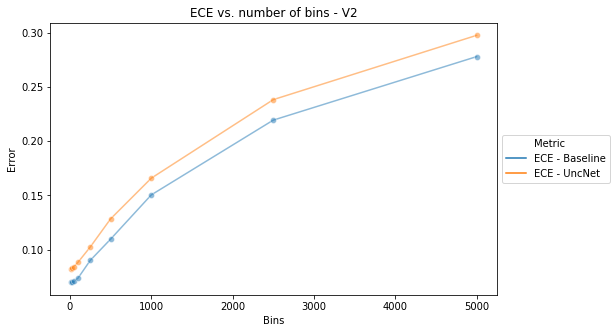

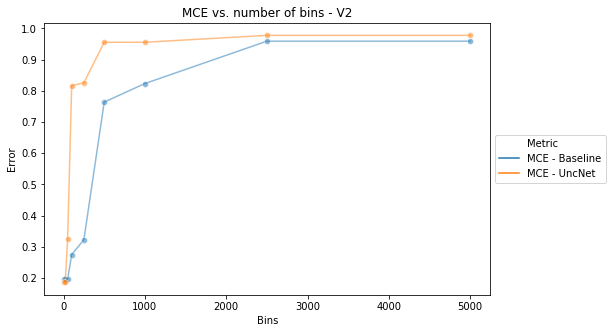

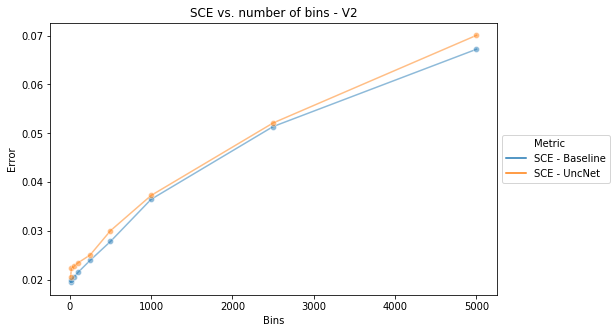

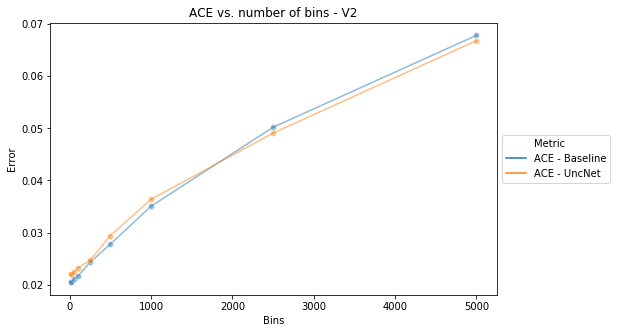

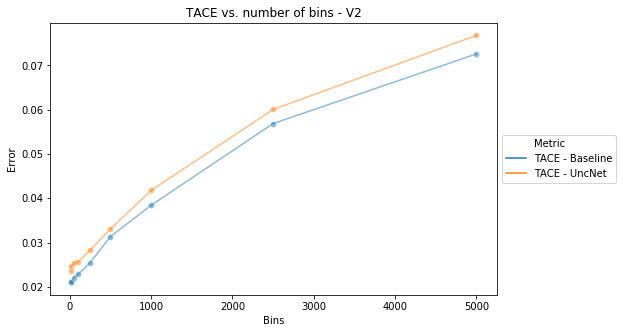

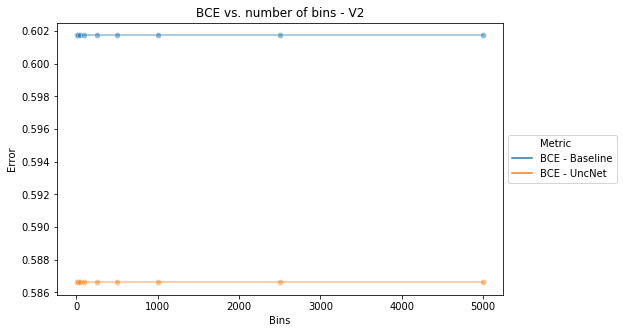

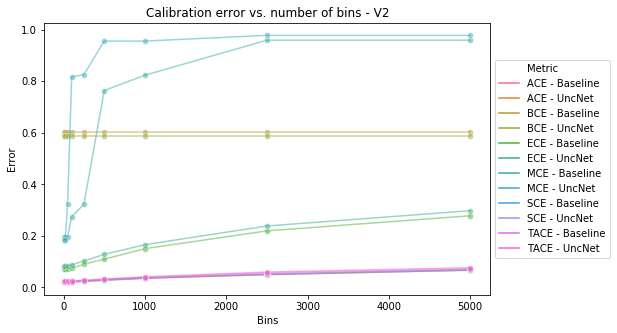

In [304]:
def plot_calib_results(baseline_pred, uncnet_pred, true, bs=[10, 20, 50, 100, 250, 500, 1000, 2500, 5000]):
    def make_df(pred, true, cond):
        eces = []
        mces = []
        sces = []
        aces = []
        taces = []
        bces = []
        for b in bs:
            _, ece, mce, sce, ace, _, tace, _, bce = calibration(np.argmax(true, axis=1), np.array(pred), n_bins=b)
            eces += [ece]
            mces += [mce]
            sces += [sce]
            aces += [ace]
            taces += [tace]
            bces += [bce]
            print (f'Bin {b} done.')
        plot_df = pd.DataFrame()
        plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':eces, 'Metric': f'ECE - {cond}'}))
        plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':mces, 'Metric': f'MCE - {cond}'}))
        plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':sces, 'Metric': f'SCE - {cond}'}))
        plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':aces, 'Metric': f'ACE - {cond}'}))
        plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':taces, 'Metric': f'TACE - {cond}'}))
        plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':bces, 'Metric': f'BCE - {cond}'}))
        return plot_df
    baseline_plot_df = make_df(baseline_pred, true, 'Baseline')
    uncnet_plot_df = make_df(uncnet_pred, true, 'UncNet')
    plot_df = pd.concat([baseline_plot_df, uncnet_plot_df], ignore_index=True)
    plot_df = plot_df.sort_values(by='Metric').reset_index(drop=True)
    
    for err in ['ECE', 'MCE', 'SCE', 'ACE', 'TACE', 'BCE']:
        sub_df = pd.concat([baseline_plot_df[baseline_plot_df['Metric'] == f'{err} - Baseline'], 
                            uncnet_plot_df[uncnet_plot_df['Metric'] == f'{err} - UncNet']], ignore_index=True)
        plt.figure(figsize=(8,5))
        sns.lineplot(x='Bins', y='Error', hue='Metric', data=sub_df, alpha=0.5, marker="o")
        plt.title(f'{err} vs. number of bins - V2')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.figure(figsize=(8,5))
    sns.lineplot(x='Bins', y='Error', hue='Metric', data=plot_df, alpha=0.5, marker="o")
    plt.title('Calibration error vs. number of bins - V2')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plot_calib_results(baseline_class_probabilities, uncnet_class_probabilities, test_labels)

Bin 10 done.
Bin 20 done.
Bin 50 done.


/mas/u/asma_gh/venvs/uncnet/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mas/u/asma_gh/venvs/uncnet/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Bin 100 done.
Bin 250 done.
Bin 500 done.
Bin 1000 done.
Bin 2500 done.
Bin 5000 done.
Bin 10 done.
Bin 20 done.
Bin 50 done.
Bin 100 done.
Bin 250 done.
Bin 500 done.
Bin 1000 done.
Bin 2500 done.
Bin 5000 done.
Bin 10 done.


/mas/u/asma_gh/venvs/uncnet/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Bin 20 done.
Bin 50 done.
Bin 100 done.
Bin 250 done.
Bin 500 done.
Bin 1000 done.
Bin 2500 done.
Bin 5000 done.
     Bins     Error                     Metric
5      10  0.003934             ACE - Baseline
12     10  0.000003   ACE - True Probabilities
24     10  0.005235               ACE - UncNet
27     10  0.660639             BCE - Baseline
43     10  0.317057   BCE - True Probabilities
53     10  0.648722               BCE - UncNet
54     10  0.023349             ECE - Baseline
67     10  0.000014   ECE - True Probabilities
72     10  0.017558               ECE - UncNet
86     10  0.062309             MCE - Baseline
93     10  0.000065   MCE - True Probabilities
100    10  0.110342               MCE - UncNet
110    10  0.004791             SCE - Baseline
119    10  0.000003   SCE - True Probabilities
127    10  0.004297               SCE - UncNet
136    10  0.003927            TACE - Baseline
149    10  0.000007  TACE - True Probabilities
154    10  0.005137              TACE - U

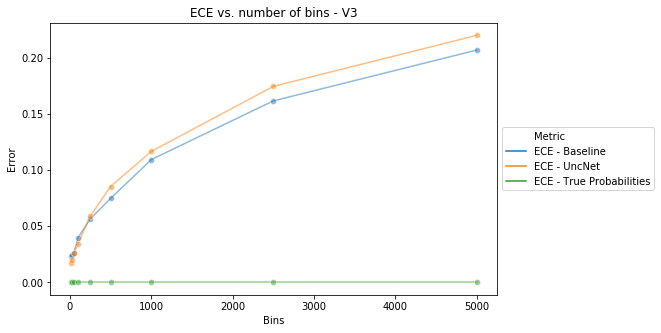

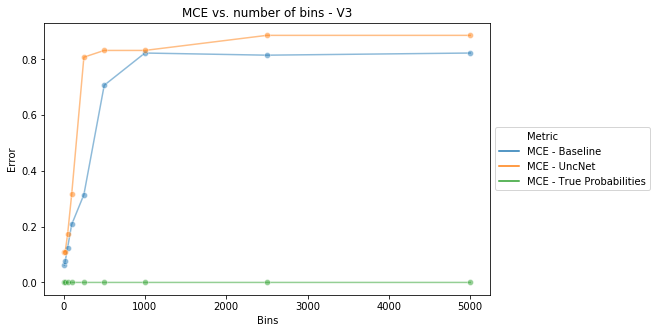

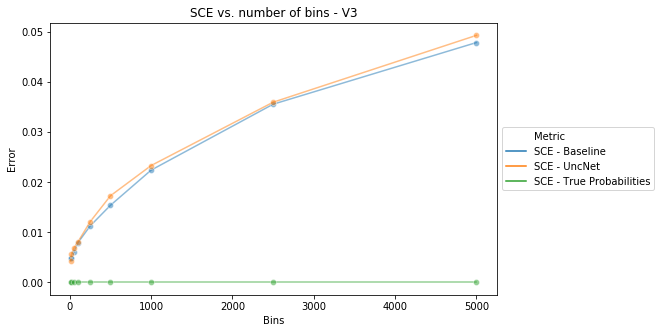

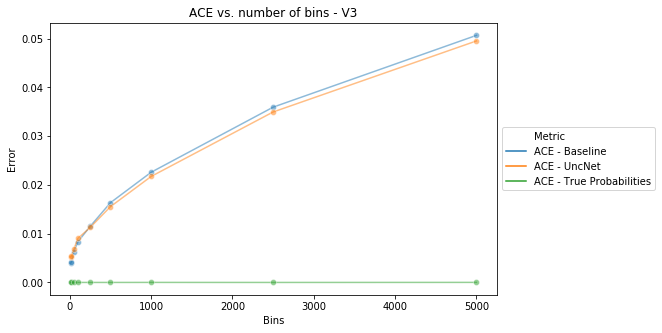

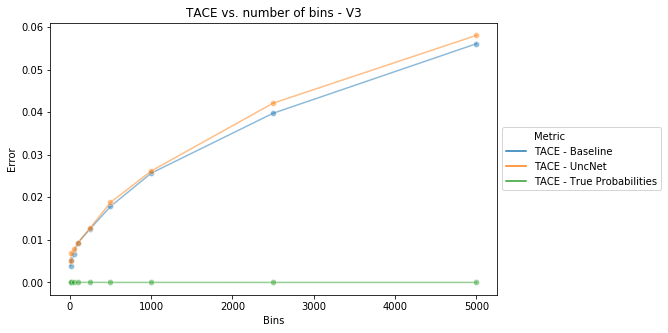

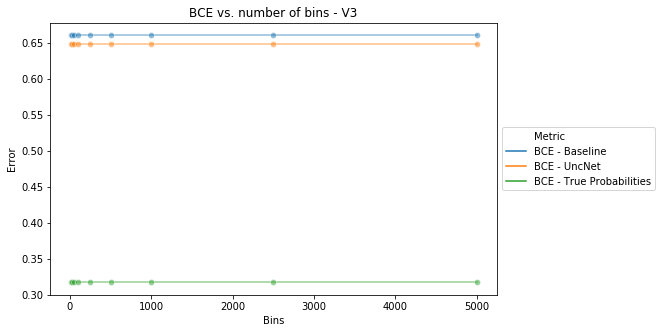

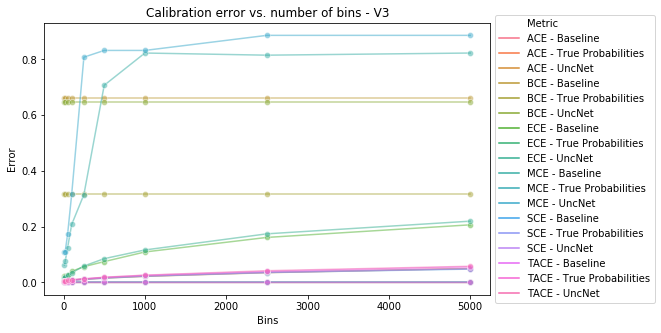

In [305]:
# Repeat samples per annotation

def plot_calib_results_flat(baseline_pred, uncnet_pred, true, bs=[10, 20, 50, 100, 250, 500, 1000, 2500, 5000]):
    def make_df_flat(pred, true, cond):
        eces = []
        mces = []
        sces = []
        aces = []
        taces = []
        bces = []
        
        flat_true = []
        flat_pred = []
        for i in range(len(true)):
            row_true = true[i]*10
            row_pred = pred[i]
            for j in range(len(row_true)):
                cell_true = row_true[j]
                flat_true += [j] * int(cell_true)
                flat_pred += [row_pred] * int(cell_true)
#         pred_prime = np.repeat(pred, 10, axis=0)
#         true_prime = [[i]*int(true[j,i]) for j in range(len(true)) for i in range(9)]
#         flattened_true = [item for sublist in true_prime for item in sublist]
        for b in bs:
            _, ece, mce, sce, ace, _, tace, _, bce = calibration(np.array(flat_true), np.array(flat_pred), n_bins=b)
            eces += [ece]
            mces += [mce]
            sces += [sce]
            aces += [ace]
            taces += [tace]
            bces += [bce]
            print (f'Bin {b} done.')
        plot_df = pd.DataFrame()
        plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':eces, 'Metric': f'ECE - {cond}'}))
        plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':mces, 'Metric': f'MCE - {cond}'}))
        plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':sces, 'Metric': f'SCE - {cond}'}))
        plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':aces, 'Metric': f'ACE - {cond}'}))
        plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':taces, 'Metric': f'TACE - {cond}'}))
        plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':bces, 'Metric': f'BCE - {cond}'}))
        return plot_df
    baseline_plot_df = make_df_flat(baseline_pred, true, 'Baseline')
    uncnet_plot_df = make_df_flat(uncnet_pred, true, 'UncNet')
    true_plot_df = make_df_flat(true, true, 'True Probabilities')
    plot_df = pd.concat([baseline_plot_df, uncnet_plot_df, true_plot_df], ignore_index=True)
    plot_df = plot_df.sort_values(by='Metric').reset_index(drop=True)
    
    for err in ['ECE', 'MCE', 'SCE', 'ACE', 'TACE', 'BCE']:
        sub_df = pd.concat([baseline_plot_df[baseline_plot_df['Metric'] == f'{err} - Baseline'], 
                            uncnet_plot_df[uncnet_plot_df['Metric'] == f'{err} - UncNet'],
                            true_plot_df[true_plot_df['Metric'] == f'{err} - True Probabilities']], ignore_index=True)
        plt.figure(figsize=(8,5))
        sns.lineplot(x='Bins', y='Error', hue='Metric', data=sub_df, alpha=0.5, marker="o")
        plt.title(f'{err} vs. number of bins - V3')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    print(plot_df[plot_df['Bins'] == 10])

    plt.figure(figsize=(8,5))
    sns.lineplot(x='Bins', y='Error', hue='Metric', data=plot_df, alpha=0.5, marker="o")
    plt.title('Calibration error vs. number of bins - V3')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plot_calib_results_flat(baseline_class_probabilities, uncnet_class_probabilities, test_labels)

### debugging and exploring calibration metrics and their dependance on binning

In [308]:
t_acc = [0.1, 0.5, 0.9]
t_conf = [.1, .5, .9]
t_biased_conf = [.2, .6, 1.0]
t_variance_conf = [.4, .2, .5]
t_outlier_conf = [.9, .55, .85]

def dbg_metric(acc, conf, ttl):
    print (f'\n{ttl}')
    granular_diff = [np.abs(acc[i] - conf[i]) for i in range(len(acc))]
    print (granular_diff)
    print ('Big bin:\t |avg(acc)-avg(conf)|= ', np.abs(np.mean(acc)-np.mean(conf)))
    print ('Small bin ECE:\t avg(|acc-conf|)= ', np.mean(granular_diff))
    print ('Smal bin MCE:\t max(|acc-conf|)= ', np.max(granular_diff))

dbg_metric(t_acc, t_conf, 'sanity check')
dbg_metric(t_acc, t_biased_conf, 'biased')
dbg_metric(t_acc, t_variance_conf, 'high variance')
dbg_metric(t_acc, t_outlier_conf, 'outlier')


sanity check
[0.0, 0.0, 0.0]
Big bin:	 |avg(acc)-avg(conf)|=  0.0
Small bin ECE:	 avg(|acc-conf|)=  0.0
Smal bin MCE:	 max(|acc-conf|)=  0.0

biased
[0.1, 0.09999999999999998, 0.09999999999999998]
Big bin:	 |avg(acc)-avg(conf)|=  0.09999999999999998
Small bin ECE:	 avg(|acc-conf|)=  0.09999999999999998
Smal bin MCE:	 max(|acc-conf|)=  0.1

high variance
[0.30000000000000004, 0.3, 0.4]
Big bin:	 |avg(acc)-avg(conf)|=  0.1333333333333333
Small bin ECE:	 avg(|acc-conf|)=  0.3333333333333333
Smal bin MCE:	 max(|acc-conf|)=  0.4

outlier
[0.8, 0.050000000000000044, 0.050000000000000044]
Big bin:	 |avg(acc)-avg(conf)|=  0.2666666666666667
Small bin ECE:	 avg(|acc-conf|)=  0.30000000000000004
Smal bin MCE:	 max(|acc-conf|)=  0.8


#### Calibration sanity check

In [283]:
print (scipy.spatial.distance.jensenshannon([0, 0, 0.0, 1.0], [0.0, 0.0, 0.1, 0.9]))
print (scipy.spatial.distance.jensenshannon([0, 0, 0.0, 1.0], [0.0, 0.05, 0.05, 0.9]))
print (scipy.spatial.distance.jensenshannon([0, 0, 0.0, 1.0], [0.025, 0.025, 0.05, 0.9]))
print (scipy.spatial.distance.jensenshannon([0, 0, 0.0, 1.0], [.2, 0.0, 0.0, 0.8]))
print (scipy.spatial.distance.jensenshannon([0, 0, 0.0, 1.0], [0., 0.2, 0.0, 0.8]))
print()
print (scipy.stats.entropy([0, 0, 0.0, 1.0], [0.0, 0.0, 0.1, 0.9]))
print (scipy.stats.entropy([0, 0, 0.0, 1.0], [0.0, 0.05, 0.05, 0.9]))
print (scipy.stats.entropy([0, 0, 0.0, 1.0], [0.025, 0.025, 0.05, 0.9]))
print (scipy.stats.entropy([0, 0, 0.0, 1.0], [0.0, 0.0, 0.05, 0.95]))

print()
print (scipy.stats.entropy([0, 0, 0.9, .1], [0.0, 0.0, 0.9, 0.1]))
print (scipy.stats.entropy([0, 0, 0.9, .1], [0.0, 0.0, 0.8, 0.2]))
print (scipy.stats.entropy([0, 0, 0.9, .1], [0.0, 0.1, 0.8, 0.1]))

print()
print (scipy.spatial.distance.jensenshannon([0, 0, 0.9, .1], [0.0, 0.0, 0.9, 0.1]))
print (scipy.spatial.distance.jensenshannon([0, 0, 0.9, .1], [0.0, 0.0, 0.8, 0.2]))
print (scipy.spatial.distance.jensenshannon([0, 0, 0.9, .1], [0.0, 0.1, 0.8, 0.1]))

0.18966748970276492
0.18966748970276492
0.18966748970276492
0.2736453208486386
0.2736453208486386

0.10536051565782635
0.10536051565782635
0.10536051565782635
0.05129329438755048

0.0
0.036690014034750584
0.10600473209074511

0.0
0.09983180525850865
0.19007576523428807


/mas/u/asma_gh/venvs/uncnet/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mas/u/asma_gh/venvs/uncnet/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Bin 10 done.
Bin 20 done.
Bin 50 done.
Bin 100 done.
Bin 250 done.
Bin 500 done.
Bin 1000 done.
Bin 2500 done.
Bin 5000 done.


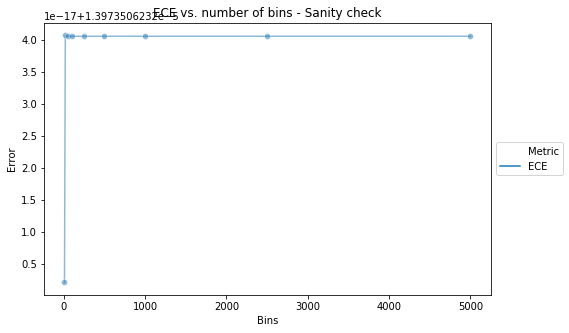

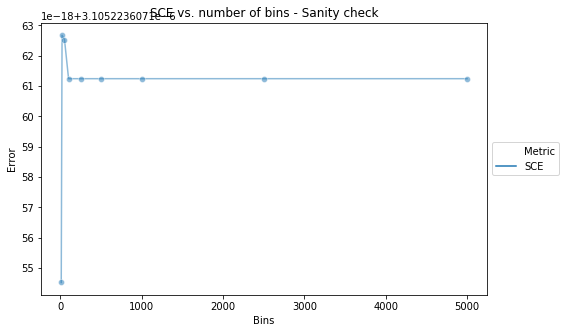

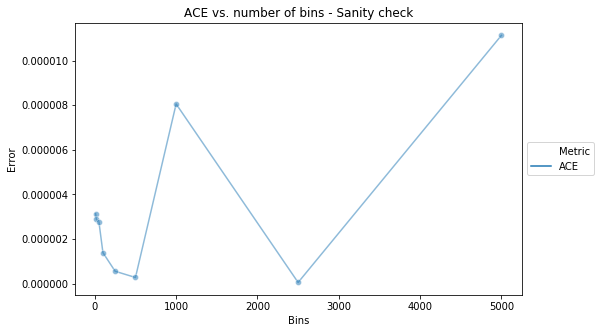

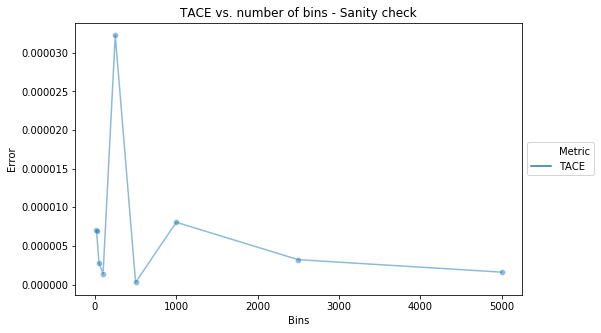

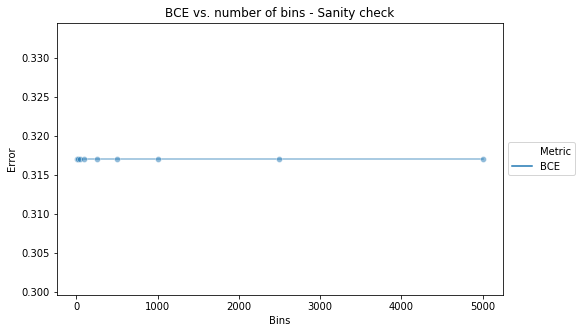

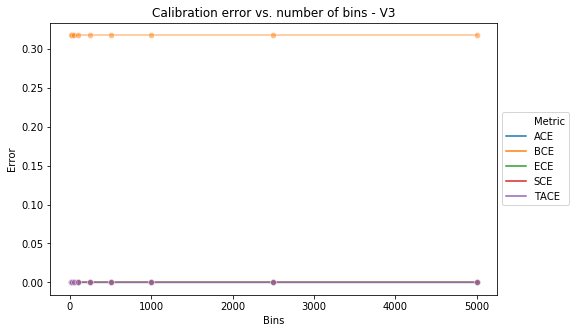

In [255]:
# Instead of using distributions, use a sampling approach
def plot_calib_results_sanity_check(true, bs=[10, 20, 50, 100, 250, 500, 1000, 2500, 5000]):
    def make_df_sanity_check(true):
        eces = []
        sces = []
        aces = []
        taces = []
        bces = []
        
        flat_true = []
        flat_pred = []
        for i in range(len(true)):
            row_true = true[i]*10
            row_pred = true[i]
            for j in range(len(row_true)):
                cell_true = row_true[j]
                flat_true += [j] * int(cell_true)
                flat_pred += [row_pred] * int(cell_true)
        for b in bs:
            _, ece, sce, ace, _, tace, _, bce = calibration(np.array(flat_true), np.array(flat_pred), n_bins=b)
            eces += [ece]
            sces += [sce]
            aces += [ace]
            taces += [tace]
            bces += [bce]
            print (f'Bin {b} done.')
        plot_df = pd.DataFrame()
        plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':eces, 'Metric': f'ECE'}))
        plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':sces, 'Metric': f'SCE'}))
        plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':aces, 'Metric': f'ACE'}))
        plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':taces, 'Metric': f'TACE'}))
        plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':bces, 'Metric': f'BCE'}))
        return plot_df
    plot_df = make_df_sanity_check(true)
    plot_df = plot_df.sort_values(by='Metric').reset_index(drop=True)
    
    for err in ['ECE', 'SCE', 'ACE', 'TACE', 'BCE']:
        sub_df = plot_df[plot_df['Metric'] == err]
        plt.figure(figsize=(8,5))
        sns.lineplot(x='Bins', y='Error', hue='Metric', data=sub_df, alpha=0.5, marker="o")
        plt.title(f'{err} vs. number of bins - Sanity check')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.figure(figsize=(8,5))
    sns.lineplot(x='Bins', y='Error', hue='Metric', data=plot_df, alpha=0.5, marker="o")
    plt.title('Calibration error vs. number of bins - V3')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plot_calib_results_sanity_check(test_labels)


Bin 10 done.
Bin 20 done.
Bin 50 done.
Bin 100 done.
Bin 250 done.
Bin 500 done.
Bin 1000 done.
Bin 2500 done.
Bin 5000 done.
Bin 10 done.
Bin 20 done.
Bin 50 done.
Bin 100 done.
Bin 250 done.
Bin 500 done.
Bin 1000 done.
Bin 2500 done.
Bin 5000 done.


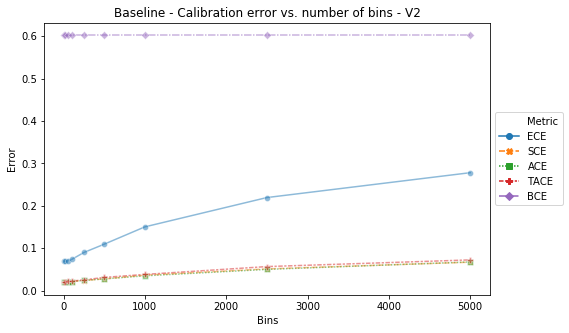

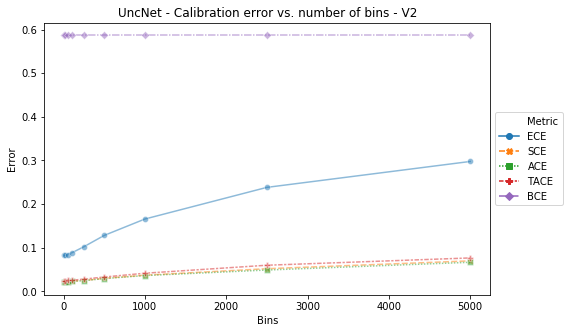

In [187]:
def plot_calib_scatter_results(pred, true, ttl, bs=[10, 20, 50, 100, 250, 500, 1000, 2500, 5000]):
    eces = []
    sces = []
    aces = []
    taces = []
    bces = []
    for b in bs:
        _, ece, sce, ace, _, tace, _, bce = calibration(np.argmax(true, axis=1), np.array(pred), n_bins=b)
        eces += [ece]
        sces += [sce]
        aces += [ace]
        taces += [tace]
        bces += [bce]
        print (f'Bin {b} done.')
    plot_df = pd.DataFrame()
    plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':eces, 'Metric': 'ECE'}))
    plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':sces, 'Metric': 'SCE'}))
    plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':aces, 'Metric': 'ACE'}))
    plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':taces, 'Metric': 'TACE'}))
    plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':bces, 'Metric': 'BCE'}))
    
    plt.figure(figsize=(8,5))
#     sns.scatterplot(x='Bins', y='Error', hue='Metric', data=plot_df, alpha=0.5)
    sns.lineplot(x='Bins', y='Error', hue='Metric', data=plot_df, alpha=0.5, markers=True, style='Metric')
    plt.title(ttl)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plot_calib_scatter_results(baseline_class_probabilities, test_labels, 
                           ttl='Baseline - Calibration error vs. number of bins - V2')
plot_calib_scatter_results(uncnet_class_probabilities, test_labels, 
                           ttl='UncNet - Calibration error vs. number of bins - V2')

#### Legacy: AG's implementation of ECE, SCE, ACE

In [88]:
# AG's implementation
def create_calib_df(pred, true):
    # n: #datapoints, k: #classes
    (n, k) = np.shape(pred)

    df = pd.DataFrame()
    df['true_max_class'] = np.argmax(true, axis=1)
    df['pred_max_class'] = np.argmax(pred, axis=1)
    df['is_correct'] = df['true_max_class']==df['pred_max_class']
    df['pred_max_conf'] = np.max(pred, axis=1)
    for i in range(k):
        df[f'pred_{i}_conf'] = pred[:,i]
        df[f'true_{i}_class'] = df['true_max_class']==i
        df[f'pred_{i}_class'] = df['pred_max_class']==i
        df[f'is_correct_{i}'] = df[f'true_{i}_class']==df[f'pred_{i}_class']
    return df

def calc_ece(df, n, k, b=10):
    # n: #datapoints, k: #classes, b: #bins or ranges
    ece = 0
    conf_step = 1.0/float(b)
    for i in range(b):
        conf_min = i * conf_step
        conf_max = (i+1) * conf_step
        pred_bin_df = df[df['pred_max_conf']>=conf_min]
        pred_bin_df = pred_bin_df[pred_bin_df['pred_max_conf']<conf_max]
        n_b = len(pred_bin_df)
        if n_b>0:
            acc_b = np.nanmean(pred_bin_df['is_correct'])
            conf_b = np.nanmean(pred_bin_df['pred_max_conf'])
            ece += n_b/float(n)*np.abs(acc_b - conf_b)
    return ece

def calc_sce(df, n, k, b=10):
    # n: #datapoints, k: #classes, b: #bins or ranges
    sce = 0
    conf_step = 1.0/float(b)
    for j in range(k):
        for i in range(b):
            conf_min = i * conf_step
            conf_max = (i+1) * conf_step
            pred_bin_df = df[df[f'pred_{j}_conf']>=conf_min]
            pred_bin_df = pred_bin_df[pred_bin_df[f'pred_{j}_conf']<conf_max]
            n_b_k = len(pred_bin_df)
            if n_b_k>0:
                acc_b_k = np.mean(pred_bin_df[f'is_correct_{j}'])
                conf_b_k = np.mean(pred_bin_df[f'pred_{j}_conf'])
                sce += n_b_k/float(n)*np.abs(acc_b_k - conf_b_k)
    sce = sce/float(k)
    return sce

def calc_ace(df, n, k, b=10):
    # n: #datapoints, k: #classes, b: #bins or ranges
    ace = 0
    conf_step = int(n/b)
    for j in range(k):
        sorted_conf = np.sort(df[f'pred_{j}_conf'])
        for i in range(b):
            conf_min = sorted_conf[i*conf_step]
            if i==b-1:
                conf_max = 1.0
            else:
                conf_max = sorted_conf[(i+1)*conf_step]
            pred_bin_df = df[df[f'pred_{j}_conf']>=conf_min]
            pred_bin_df = pred_bin_df[pred_bin_df[f'pred_{j}_conf']<conf_max]
            n_b_k = len(pred_bin_df)
            if n_b_k>0:
                acc_b_k = np.mean(pred_bin_df[f'is_correct_{j}'])
                conf_b_k = np.mean(pred_bin_df[f'pred_{j}_conf'])
                ace += n_b_k/float(n)*np.abs(acc_b_k - conf_b_k)         
    ace = ace/float(k)
    return ace
    
def calc_calib(pred, true, b=10):
    # n: #datapoints, k: #classes, b: #bins or ranges
    (n, k) = np.shape(pred)
    df = create_calib_df(np.array(pred), np.array(true))
    ece = calc_ece(df, n, k, b)
    sce = calc_sce(df, n, k, b)
    ace = calc_ace(df, n, k, b)
#     tace = 0
#     epsilon = 0.1
    return df, ece, sce, ace


baseline_cal_df, baseline_ece, baseline_sce, baseline_ace = calc_calib(baseline_class_probabilities, test_labels)
uncnet_cal_df, uncnet_ece, uncnet_sce, uncnet_ace = calc_calib(uncnet_class_probabilities, test_labels)
    
print (f'Baseline:\nECE={baseline_ece}, SCE={baseline_sce}, ACE={baseline_ace}\n\n'
       f'UncNet:\nECE={uncnet_ece}, SCE={uncnet_sce}, ACE={uncnet_ace}')

Baseline:
ECE=0.069681033004959, SCE=0.7886026379125263, ACE=0.7885504932122727

UncNet:
ECE=0.08244459465516617, SCE=0.7937793995650345, ACE=0.7930210184597845


In [106]:
def plot_calib(pred, true, ttl, bs=[10, 20, 50, 100, 250, 500, 1000, 2500, 5000]):
    # n: #datapoints, k: #classes, b: #bins or ranges
    (n, k) = np.shape(pred)
    df = create_calib_df(np.array(pred), np.array(true))
    eces = []
    sces = []
    aces = []
    for b in bs:
        eces += [calc_ece(df, n, k, b)]
        sces += [calc_sce(df, n, k, b)]
        aces += [calc_ace(df, n, k, b)]
        print (f'Bin {b} done.')
    plot_df = pd.DataFrame()
    plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':eces, 'Metric': 'ECE'}))
    plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':sces, 'Metric': 'SCE'}))
    plot_df = plot_df.append(pd.DataFrame(data= {'Bins': bs, 'Error':aces, 'Metric': 'ACE'}))
    
    plt.figure(figsize=(8,5))
    sns.scatterplot(x='Bins', y='Error', hue='Metric', data=plot_df, alpha=0.5)
    plt.title(ttl)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Bin 10 done.
Bin 20 done.
Bin 50 done.
Bin 100 done.
Bin 250 done.
Bin 500 done.
Bin 1000 done.
Bin 2500 done.
Bin 5000 done.


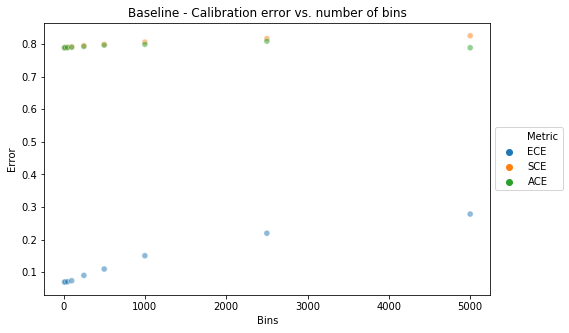

In [120]:
plot_calib(baseline_class_probabilities, test_labels, ttl='Baseline - Calibration error vs. number of bins') #, bs=[5, 10]

Bin 10 done.
Bin 20 done.
Bin 50 done.
Bin 100 done.
Bin 250 done.
Bin 500 done.
Bin 1000 done.
Bin 2500 done.
Bin 5000 done.


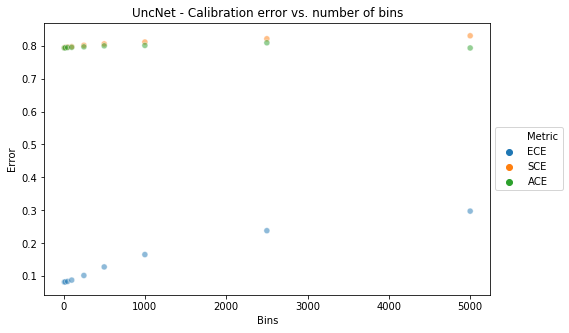

In [108]:
plot_calib(uncnet_class_probabilities, test_labels, ttl='UncNet - Calibration error vs. number of bins') #, bs=[5, 10]

In [89]:
baseline_cal_df, baseline_ece, baseline_sce, baseline_ace = calc_calib(baseline_class_probabilities, test_labels, b=1000)
uncnet_cal_df, uncnet_ece, uncnet_sce, uncnet_ace = calc_calib(uncnet_class_probabilities, test_labels, b=1000)
    
print (f'Baseline:\nECE={baseline_ece}, SCE={baseline_sce}, ACE={baseline_ace}\n\n'
       f'UncNet:\nECE={uncnet_ece}, SCE={uncnet_sce}, ACE={uncnet_ace}')

Baseline:
ECE=0.15046118977150477, SCE=0.8056186143523159, ACE=0.7990322198215909

UncNet:
ECE=0.16589138307745258, SCE=0.8110256694916388, ACE=0.8007891756449761


## Using JS distance

In [17]:
def print_distance_metrics(pred, true, ttl):
    print ('\n'+ttl)
    js_s = []
    s_sim_s =[]
    for i in range(len(pred)):
        js_s.append(scipy.spatial.distance.jensenshannon(pred[i], true[i]))
        s_sim_s.append(scipy.spatial.distance.cosine(pred[i], true[i]))
    print (f'Jensen shannon distance: mean={np.mean(js_s):.3f}, std={np.std(js_s):.3f}')
#     print (f'Cosine similarity: mean={np.mean(s_sim_s):.3f}, std={np.std(s_sim_s):.3f}')
#     return np.mean(js_s), np.std(js_s), np.mean(s_sim_s), np.std(s_sim_s)
    return js_s

def compare_distance_metrics(js1, js2):
    t, p = scipy.stats.ttest_rel(js1, js2)
    print (f'\nt: {t:.5f}, p: {p:.5f}\n')

In [18]:
baseline_js_s = print_distance_metrics(baseline_class_probabilities, test_labels, 'Baseline')
uncnet_js_s = print_distance_metrics(uncnet_class_probabilities, test_labels, 'UncNet')

test['baseline_js'] = baseline_js_s
test['uncnet_js'] = uncnet_js_s

compare_distance_metrics(baseline_js_s, uncnet_js_s)


Baseline
Jensen shannon distance: mean=0.473, std=0.131

UncNet
Jensen shannon distance: mean=0.461, std=0.140

t: 9.33479, p: 0.00000



### What if we only look at samples that we are confident in?

In [19]:
for unc in ['aleatoric', 'epistemic', 'total']:
    print (f'\nSorting based on uncertainty type: {unc}...')
    sub_indices = find_unc_samples(test, unc)
    sub_test_embeddings = test_embeddings[sub_indices]
    sub_test_labels = test_labels[sub_indices]
    _, _, sub_baseline_class_probabilities, _, _, _= get_performance_on_data(
    BEST_CHECKPOINTS, 'none', sub_test_embeddings, sub_test_labels)

    _, _, sub_uncnet_class_probabilities, _, _, _ = get_performance_on_data(
        BEST_CHECKPOINTS, 'both', sub_test_embeddings, sub_test_labels)
    
    sub_baseline_js_s = print_distance_metrics(sub_baseline_class_probabilities, sub_test_labels, 'Baseline')
    sub_uncnet_js_s = print_distance_metrics(sub_uncnet_class_probabilities, sub_test_labels, 'UncNet')
    
    compare_distance_metrics(sub_baseline_js_s, sub_uncnet_js_s)
     


Sorting based on uncertainty type: aleatoric...
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/unc_hparam_logs/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/1e-05/epistemic/2019_04_26_13_17_00/FC_819.ckpt-819

Baseline
Jensen shannon distance: mean=0.452, std=0.133

UncNet
Jensen shannon distance: mean=0.437, std=0.143

t: 11.04683, p: 0.00000


Sorting based on uncertainty type: epistemic...
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/epoch_logs_model/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/0.0001/none/2019_04_22_10_36_21/FC_403.ckpt-403
INFO:tensorflow:Restoring parameters from /mas/u/asma_gh/uncnet/unc_hparam_logs/CASIA_WebFace_Inception_ResNet_v1/Mixed_7a/1e-05/epistemic/2019_04_26_13_17_00/FC_819.ckpt-819

Baseline
Jensen shannon distance: mean=0.466, std=0.133

UncNet
Jense

### What do these samples that we got so wrong look like?

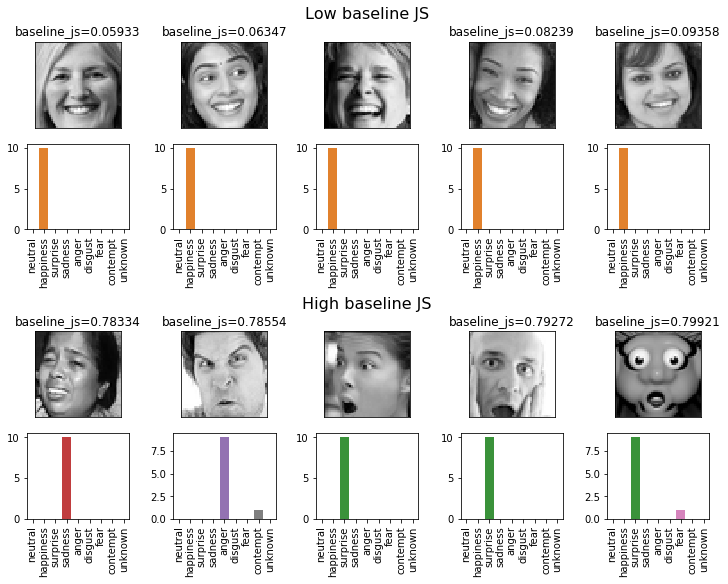

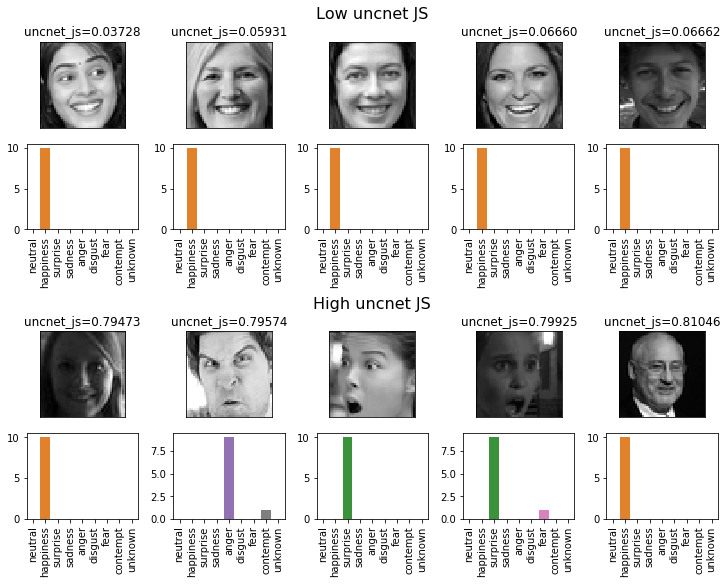

In [20]:
def plot_extreme_error_prediction_images(input_unsorted, condition, n=5):
    inp = input_unsorted.sort_values(by=f'{condition}_js', ascending=True).reset_index(drop=True)
    f, axes = plt.subplots(4, n, figsize=(n*2, 8), constrained_layout=True)
    for i in range(n):
        _plot_img_hist(inp.iloc[i], axes, 0, i, f'{condition}_js')
    axes[0, int(n/2)].set_title(f'Low {condition} JS', size=16, y=1.2)
    
    for i in range(n):
        _plot_img_hist(inp.iloc[len(inp)-1-i], axes, 2, n-i-1, f'{condition}_js')
    axes[2, int(n/2)].set_title(f'High {condition} JS', size=16, y=1.2)
    
plot_extreme_error_prediction_images(test, 'baseline')
plot_extreme_error_prediction_images(test, 'uncnet')

# Q6: Is there a correlation between uncertainty and prediction calibration of UncNet?


<Figure size 360x360 with 0 Axes>

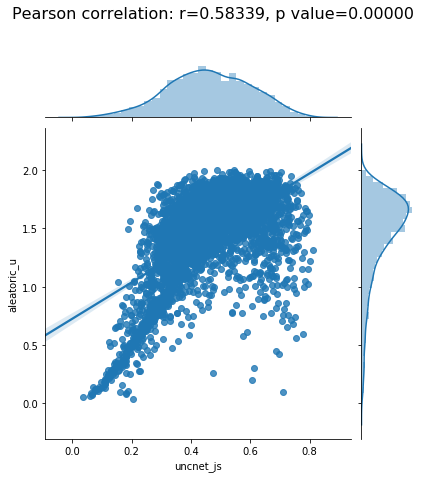

<Figure size 360x360 with 0 Axes>

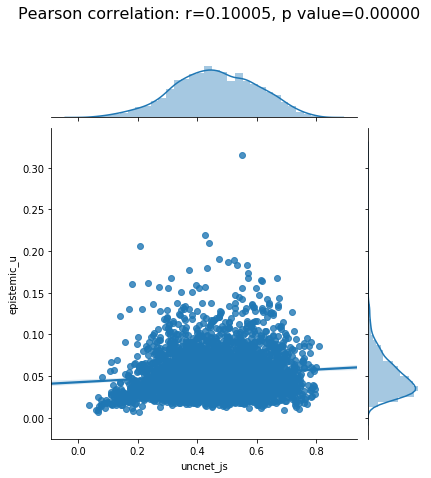

<Figure size 360x360 with 0 Axes>

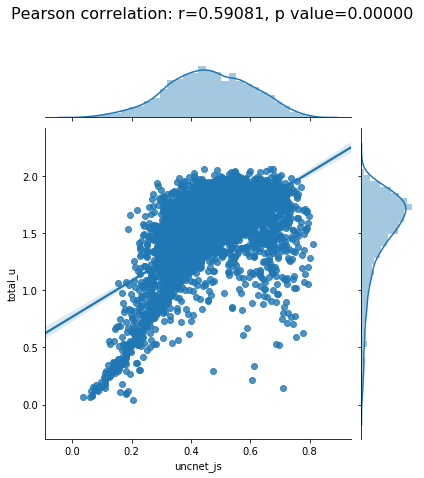

In [21]:
x = 'uncnet_js'
comparison_plots(test, x, f'aleatoric{unc_postfix}')
comparison_plots(test, x, f'epistemic{unc_postfix}')
comparison_plots(test, x, f'total{unc_postfix}')

# Q7: Edge-cases
### What we got wrong but people got right. 
### What we got right but people disagreed on.

In [22]:
# TODO debug here
def add_uncnet_predictions(series):
    for idx in np.arange(len(EMOTION_COLS)):
        emotion = EMOTION_COLS[idx]
        series[f'uncnet_{emotion}'] = series['uncnet_class_probabilities'][idx]
    return series

test['uncnet_class_probabilities'] = [list(row) for row in uncnet_class_probabilities]
test = test.apply(add_uncnet_predictions, axis=1)

uncnet_entropies = [scipy.stats.entropy(p_t) for p_t in uncnet_class_probabilities] 
test['uncnet_entropy'] = uncnet_entropies
test['diff_entropy'] = test['entropy'] - test['uncnet_entropy']

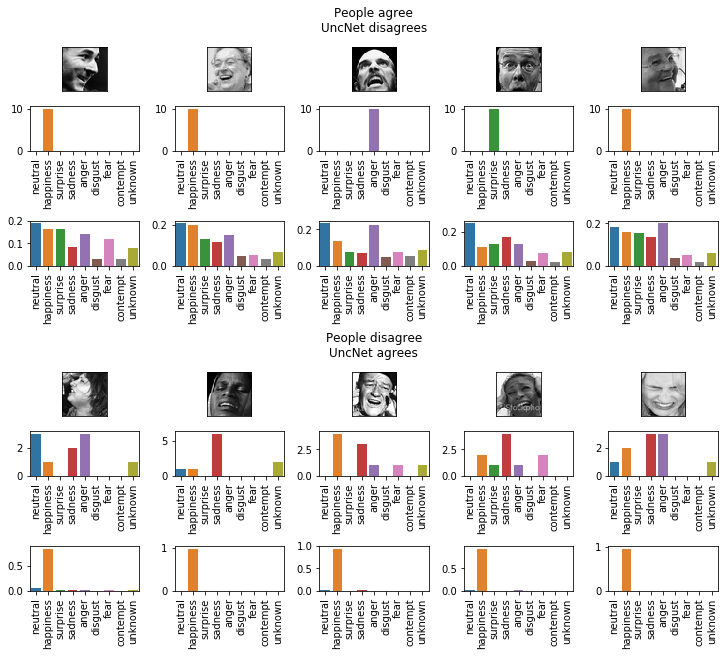

In [28]:
def _plot_img_hist_multi_ttl(inp, axes, ax_i, ax_j, ttl_cols):
    img_ax = axes[ax_i, ax_j]
    true_hist_ax = axes[ax_i+1, ax_j]
    pred_hist_ax = axes[ax_i+2, ax_j]
    
    ttl = ''
    for ttl_col in ttl_cols:
        ttl+=f'{ttl_col}={inp[ttl_col]:.3f}\n'
        
    NEW_SHAPE = (48, 48)
    img_arr = np.array([int(i) for i in inp['pixels'].split(' ')])
    img_arr = np.reshape(img_arr, NEW_SHAPE)
    img_ax.set_title(ttl)
    img_ax.imshow(img_arr, cmap='gray')
    img_ax.set_xticks([])
    img_ax.set_yticks([])
    
    sns.barplot(np.arange(len(EMOTION_COLS)), list(inp[EMOTION_COLS]), ax=true_hist_ax)
    true_hist_ax.set_xticklabels(EMOTION_COLS, rotation='vertical')
    
    sns.barplot(np.arange(len(EMOTION_COLS)), list(inp[[f'uncnet_{emotion}' for emotion in EMOTION_COLS]]),
                ax=pred_hist_ax)
    pred_hist_ax.set_xticklabels(EMOTION_COLS, rotation='vertical')
#     pred_hist_ax.set_ylim([0,1])

    
def plot_edge_cases(input_unsorted, n=5):
    inp = input_unsorted.sort_values(by='diff_entropy', ascending=True).reset_index(drop=True)
    f, axes = plt.subplots(6, n, figsize=(n*2, 9), constrained_layout=True)
    for i in range(n):
        _plot_img_hist_multi_ttl(inp.iloc[i], axes, 0, i, []) #'diff_entropy', 'uncnet_entropy', 'entropy'
    axes[0, int(n/2)].set_title(f'People agree\nUncNet disagrees', size=12, y=1.2)
    
    for i in range(n):
        _plot_img_hist_multi_ttl(inp.iloc[len(inp)-1-i], axes, 3, n-i-1, []) #'diff_entropy', 'uncnet_entropy', 'entropy'
    axes[3, int(n/2)].set_title(f'People disagree\nUncNet agrees', size=12, y=1.2)
    
plot_edge_cases(test, n=5)

In [29]:
EMOTION_COLS

['neutral',
 'happiness',
 'surprise',
 'sadness',
 'anger',
 'disgust',
 'fear',
 'contempt',
 'unknown']

# Other
### More examples

Uncertainty type: aleatoric
Uncertainty type: epistemic
Uncertainty type: total


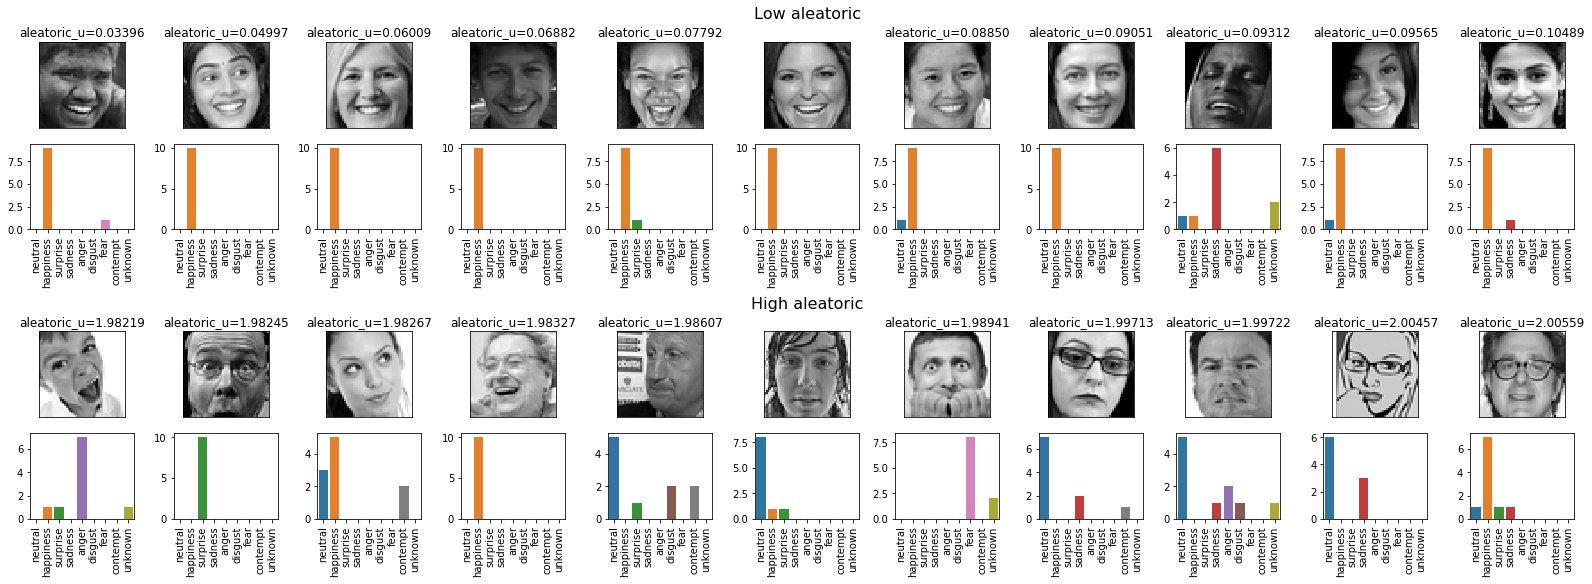

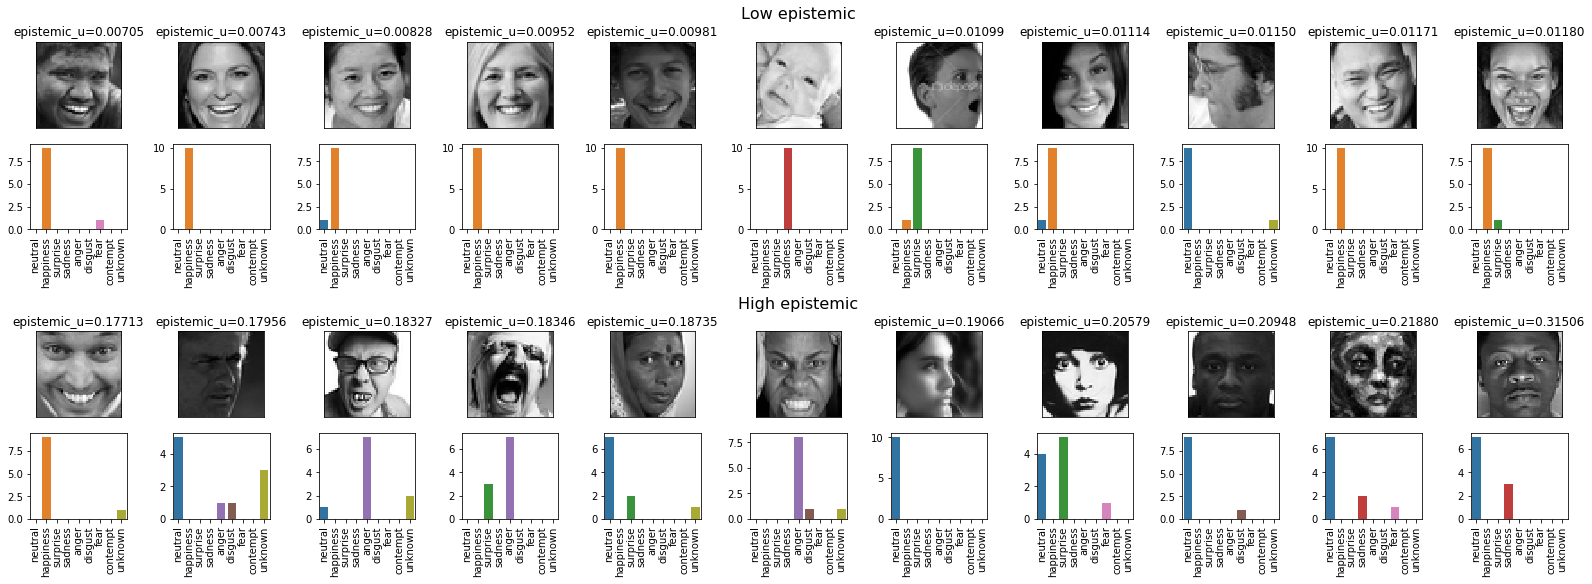

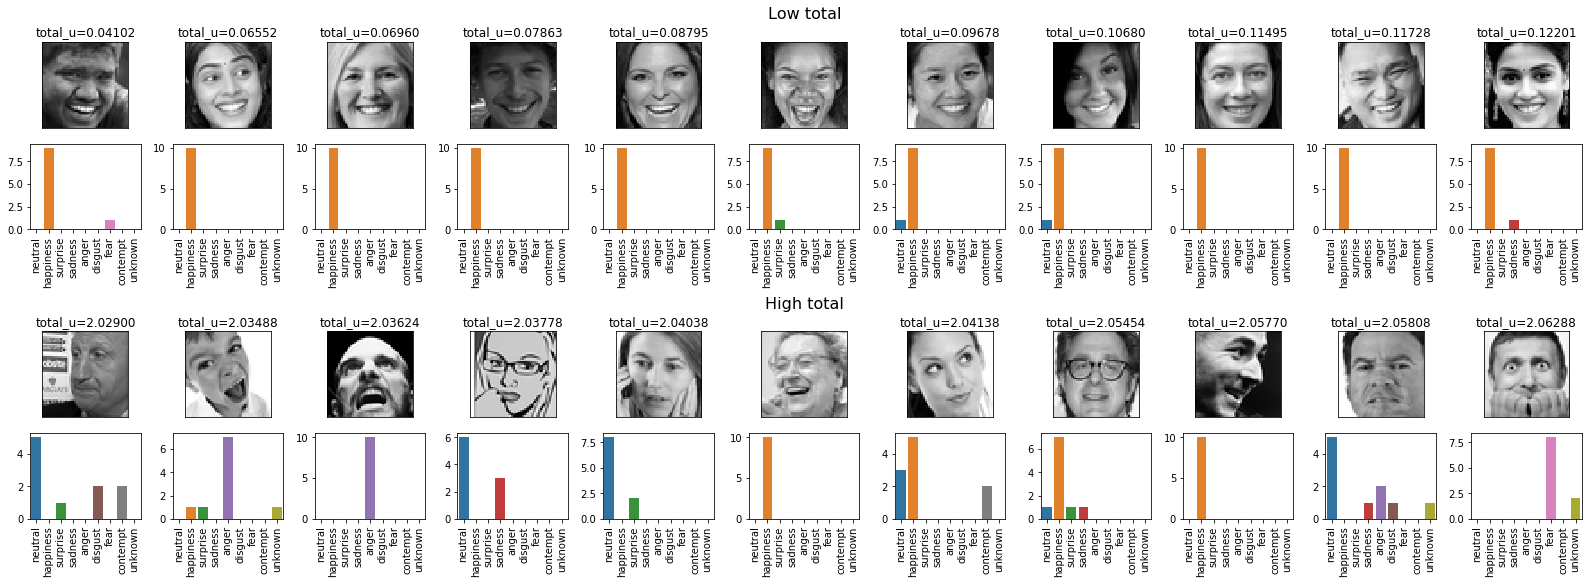

In [24]:
for unc in ['aleatoric', 'epistemic', 'total']:
    print (f'Uncertainty type: {unc}')
    sorted_test = test.sort_values(by=f'{unc}{unc_postfix}')
    show_extreme_cases(sorted_test, 11, unc)

# Post-hoc analyses for digging deeper into epistemic. Are certain classes more frequent in training data? 

E.g. Surprise is more common that other classes?

In [25]:
def post_process(series):
    idx = np.argmax(list(series[EMOTION_COLS]))
    series['target'] = EMOTION_COLS[idx]
    return series

post_processed_test = test.apply(post_process, axis=1)
post_processed_train = train.apply(post_process, axis=1)

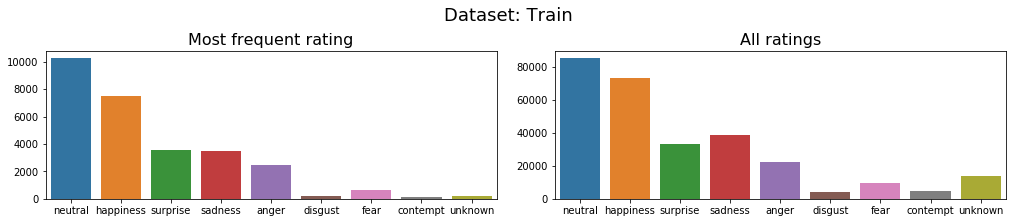

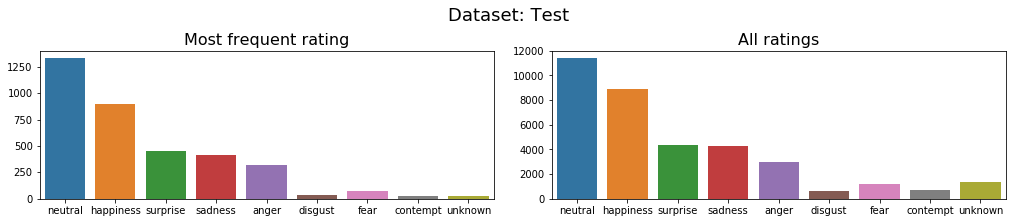

In [26]:
def plot_dataset_stats(subset, ttl):
    W = 7; H=3
    f, axes = plt.subplots(1, 2, figsize=(W*2, H), constrained_layout=True)
    plt.suptitle(f'Dataset: {ttl}', fontsize=18)
    most_frequent_vals = []
    for emotion in EMOTION_COLS:
        val = np.sum(subset['target']==emotion)
        most_frequent_vals.append(val)
    sns.barplot(x=EMOTION_COLS, y=most_frequent_vals, ax=axes[0])
    axes[0].set_title('Most frequent rating', fontsize=16)

    all_vals = []
    for emotion in EMOTION_COLS:
        val = np.sum(subset[emotion])
        all_vals.append(val)
    sns.barplot(x=EMOTION_COLS, y=all_vals, ax=axes[1])
    axes[1].set_title('All ratings', fontsize=16)
        
plot_dataset_stats(post_processed_train, 'Train')
plot_dataset_stats(post_processed_test, 'Test')

In [27]:
def print_dataset_stats(subset, ttl):
    print (f'\n\n{ttl}\n')
    print ('# of most frequent ratings of emotions...')
    most_frequent_vals=[]
    for emotion in EMOTION_COLS:
        val = np.sum(subset['target']==emotion)
        print (f'{emotion}: {val}')

    print ('\n# of total ratings of emotions...')
    for emotion in EMOTION_COLS:
        val = np.sum(subset[emotion])
        print (f'{emotion}: {val}')
        
print_dataset_stats(post_processed_train, 'Train')
print_dataset_stats(post_processed_test, 'Test')



Train

# of most frequent ratings of emotions...
neutral: 10309
happiness: 7528
surprise: 3562
sadness: 3515
anger: 2467
disgust: 191
fear: 652
contempt: 165
unknown: 170

# of total ratings of emotions...
neutral: 85563
happiness: 73454
surprise: 33074
sadness: 38538
anger: 22522
disgust: 4247
fear: 9641
contempt: 4845
unknown: 13591


Test

# of most frequent ratings of emotions...
neutral: 1335
happiness: 899
surprise: 456
sadness: 412
anger: 319
disgust: 34
fear: 74
contempt: 24
unknown: 26

# of total ratings of emotions...
neutral: 11430
happiness: 8900
surprise: 4337
sadness: 4265
anger: 3007
disgust: 616
fear: 1164
contempt: 677
unknown: 1381


# Debugging only